# Méthodes et données
## Importation des modules et données



In [ ]:
import pandas as pd
import numpy as np
# %matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer, StandardScaler

plt.style.use('seaborn-whitegrid')

import seaborn as sns
sns.set()


#récupère variable depuis autre Notebook
# %store -r trans_prod_custo_cleannan 

data_librairie = pd.read_csv("dataset_P4/data_librairie.csv", sep=",") #lire fichier csv


data_librairie_clean = data_librairie.drop(columns='Unnamed: 0')
data_librairie_without_imputation = data_librairie_clean[data_librairie_clean["client_id"] != "c_imput"]
data_librairie_without_imputation_outlier = data_librairie_without_imputation[~(data_librairie_without_imputation['client_id']== "c_1609") | (data_librairie_without_imputation['client_id']== "c_3454") | (data_librairie_without_imputation['client_id']== "c_4958") | (data_librairie_without_imputation['client_id']== "c_6714")]

data_librairie_without_imputation_outlier


## Mise en place des formules

In [2]:
def one_hot_matrix(vector,data):
    
    dataset = data.copy()
    
    one_hot_matrix = pd.get_dummies(dataset[vector],dtype='bool')

    # to merge new features
    dataset = dataset.merge(one_hot_matrix,how ='left', left_index=True, right_index=True)

    # to drop vector
    dataset = dataset.drop(vector, axis=1)

    return dataset

In [3]:
def chi2(vector_x, vector_y, data):
    
    from sklearn.feature_selection import chi2
    
    contingency_table = data[[vector_x, vector_y]].copy()
    
    columns_names     = one_hot_matrix(vector_y, contingency_table).columns[1:]
    
    contingency_table = one_hot_matrix(vector_y, contingency_table)
    contingency_table = contingency_table.groupby(vector_x).sum()

    # matrix columns
    results_matrix = pd.DataFrame(chi2(contingency_table, contingency_table.index))
    results_matrix.columns = columns_names
    results_matrix = results_matrix.T
    
    results_matrix.iloc[:,0] = round((results_matrix.iloc[:,0]/results_matrix.iloc[:,0].sum())*100)
    results_matrix.iloc[:,1] = round(results_matrix.iloc[:,1],3)
    
    results_matrix.columns = ['Khi-2 %','p-value']

    # heatmpap global settings
    plt.style.use('default')
    sns.set(font_scale=2.5)
    plt.figure(figsize=(5,5))
    
    # xi_n value title
    title = 'ξn : ' + str(xi_n(vector_x, vector_y, data))
    plt.suptitle(title, fontsize=30)

    sns.heatmap(results_matrix, annot=True, cbar=False)

    plt.show()

In [4]:
def xi_n(X, y, data):

    # to create contingency table
    contingency_table = data[[X,y]].pivot_table(index=X,
                                                columns=y,
                                                aggfunc=len,
                                                margins=True,
                                                margins_name="Total",
                                                fill_value=0)


    # to create independence table
    tx = contingency_table.loc[:,["Total"]]
    ty = contingency_table.loc[["Total"],:]
    n = len(data)
    independence_table = tx.dot(ty) / n

    # to compute xi_n
    contingency_table = contingency_table.iloc[0:4,0:4]
    independence_table = independence_table.iloc[0:4,0:4]

    measure = (contingency_table-independence_table)**2/independence_table
    xi_n = int(measure.sum().sum().round())
    
    return xi_n




In [5]:
def eta2(vector_quant, vector_quali, data):
    
    # function body
    from sklearn.feature_selection import f_classif

    # features set
    dataset = data[[vector_quant, vector_quali]].copy()

    # to set up n_samples, n_features
    dataset = one_hot_matrix(vector_quali, dataset)

    n_samples_n_features = np.array(dataset)

    # reshape(-1,1) : from scalar (1d) to vector(2d)
    n_samples = np.array(dataset.iloc[:,0]).reshape(-1,1)

    # matrix columns
    results_matrix = pd.DataFrame((f_classif(n_samples_n_features, n_samples)))
    results_matrix.columns = dataset.columns
    results_matrix.drop(vector_quant, axis=1, inplace=True)
    results_matrix = results_matrix.T
    
    results_matrix.iloc[:,0] = round((results_matrix.iloc[:,0]/results_matrix.iloc[:,0].sum())*100)
    results_matrix.iloc[:,1] = round(results_matrix.iloc[:,1],3)
    
    results_matrix.columns = ['Fisher %','p-value']

    # heatmpap global settings
    plt.style.use('default')
    sns.set(font_scale=2.5)
    plt.figure(figsize=(5,5))
    
    # eta value title
    title = 'η2 : ' + str(eta_squared(data[vector_quali], data[vector_quant]))
    plt.suptitle(title, fontsize=30)
    
    sns.heatmap(results_matrix, annot=True, cbar=False)

    plt.show()



def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
        
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    
    eta2 = round((SCE/SCT),2)
    
    if eta2==0:
        eta2=int(eta2)
    
    return eta2

# Analyse corrélation générale


## Ajout des données à analyser
### montant total acheté

In [6]:
price_client_age = data_librairie_without_imputation[["client_id", "price"]]
price_client_age_trie = (price_client_age.groupby(by=[ "client_id"]).sum().reset_index())
price_client_age_trie["total_buy"] = price_client_age_trie["price"].round().astype('int')
price_client_age_totalbuy = price_client_age_trie.drop(columns={"price"})
data_librairie_without_imputation = price_client_age_totalbuy.merge(data_librairie_without_imputation)
data_librairie_without_imputation

,client_id,total_buy,id_prod,date,session_id,price,categ,sex,birth,age transact
0,c_1,301,2_208,2021-11-04 17:28:13.934070,s_114737,54.87,2.0,m,1955,67
1,c_1,301,0_1571,2022-02-01 01:47:04.355850,s_158128,5.99,0.0,m,1955,68
2,c_1,301,1_425,2021-12-25 03:53:43.623598,s_139610,16.99,1.0,m,1955,67
3,c_1,301,1_364,2021-11-15 20:46:25.222740,s_120172,10.30,1.0,m,1955,67
4,c_1,301,1_364,2021-12-15 23:32:41.632729,s_134971,10.30,1.0,m,1955,67
...,...,...,...,...,...,...,...,...,...,...
336708,c_999,305,1_669,2022-01-16 23:40:14.387888,s_150872,15.99,1.0,m,1964,59
336709,c_999,305,0_2104,2021-10-02 20:31:58.645109,s_99070,7.98,0.0,m,1964,58
336710,c_999,305,1_247,2022-01-24 09:39:50.831782,s_154462,20.99,1.0,m,1964,59
336711,c_999,305,1_727,2021-11-21 17:40:50.856434,s_122996,16.99,1.0,m,1964,58


### Catégorie d'âge

,age transact,price
0,18,342
1,19,213
2,20,139
3,21,138
4,22,131
...,...,...
72,90,6
73,91,5
74,92,2
75,93,4


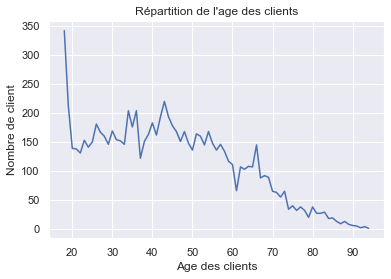

In [7]:
sns.set()

age_client = data_librairie_without_imputation.drop_duplicates(subset=['client_id']).pivot_table(values="price", index= "age transact", aggfunc= "count", margins = False).reset_index()

x = age_client["age transact"]
y =age_client["price"]
plt.plot(x,y)
plt.xlabel("Age des clients")
plt.ylabel("Nombre de client")
plt.title("Répartition de l'age des clients")
plt.savefig('./dataset_P4/age_repartition.png')

data_librairie_without_imputation["age_segment"] = np.where(data_librairie_without_imputation["age transact"] < 30, "18-30", (np.where(data_librairie_without_imputation["age transact"] > 50, "51+", "31-50")))

age_client.describe()
age_client

<ipython-input-8-184ce558df01>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["groupeage"] = pd.cut(x["age transact"], bins= range(15, 101, 5))  #.group_by("age transact", aggfunc="count")


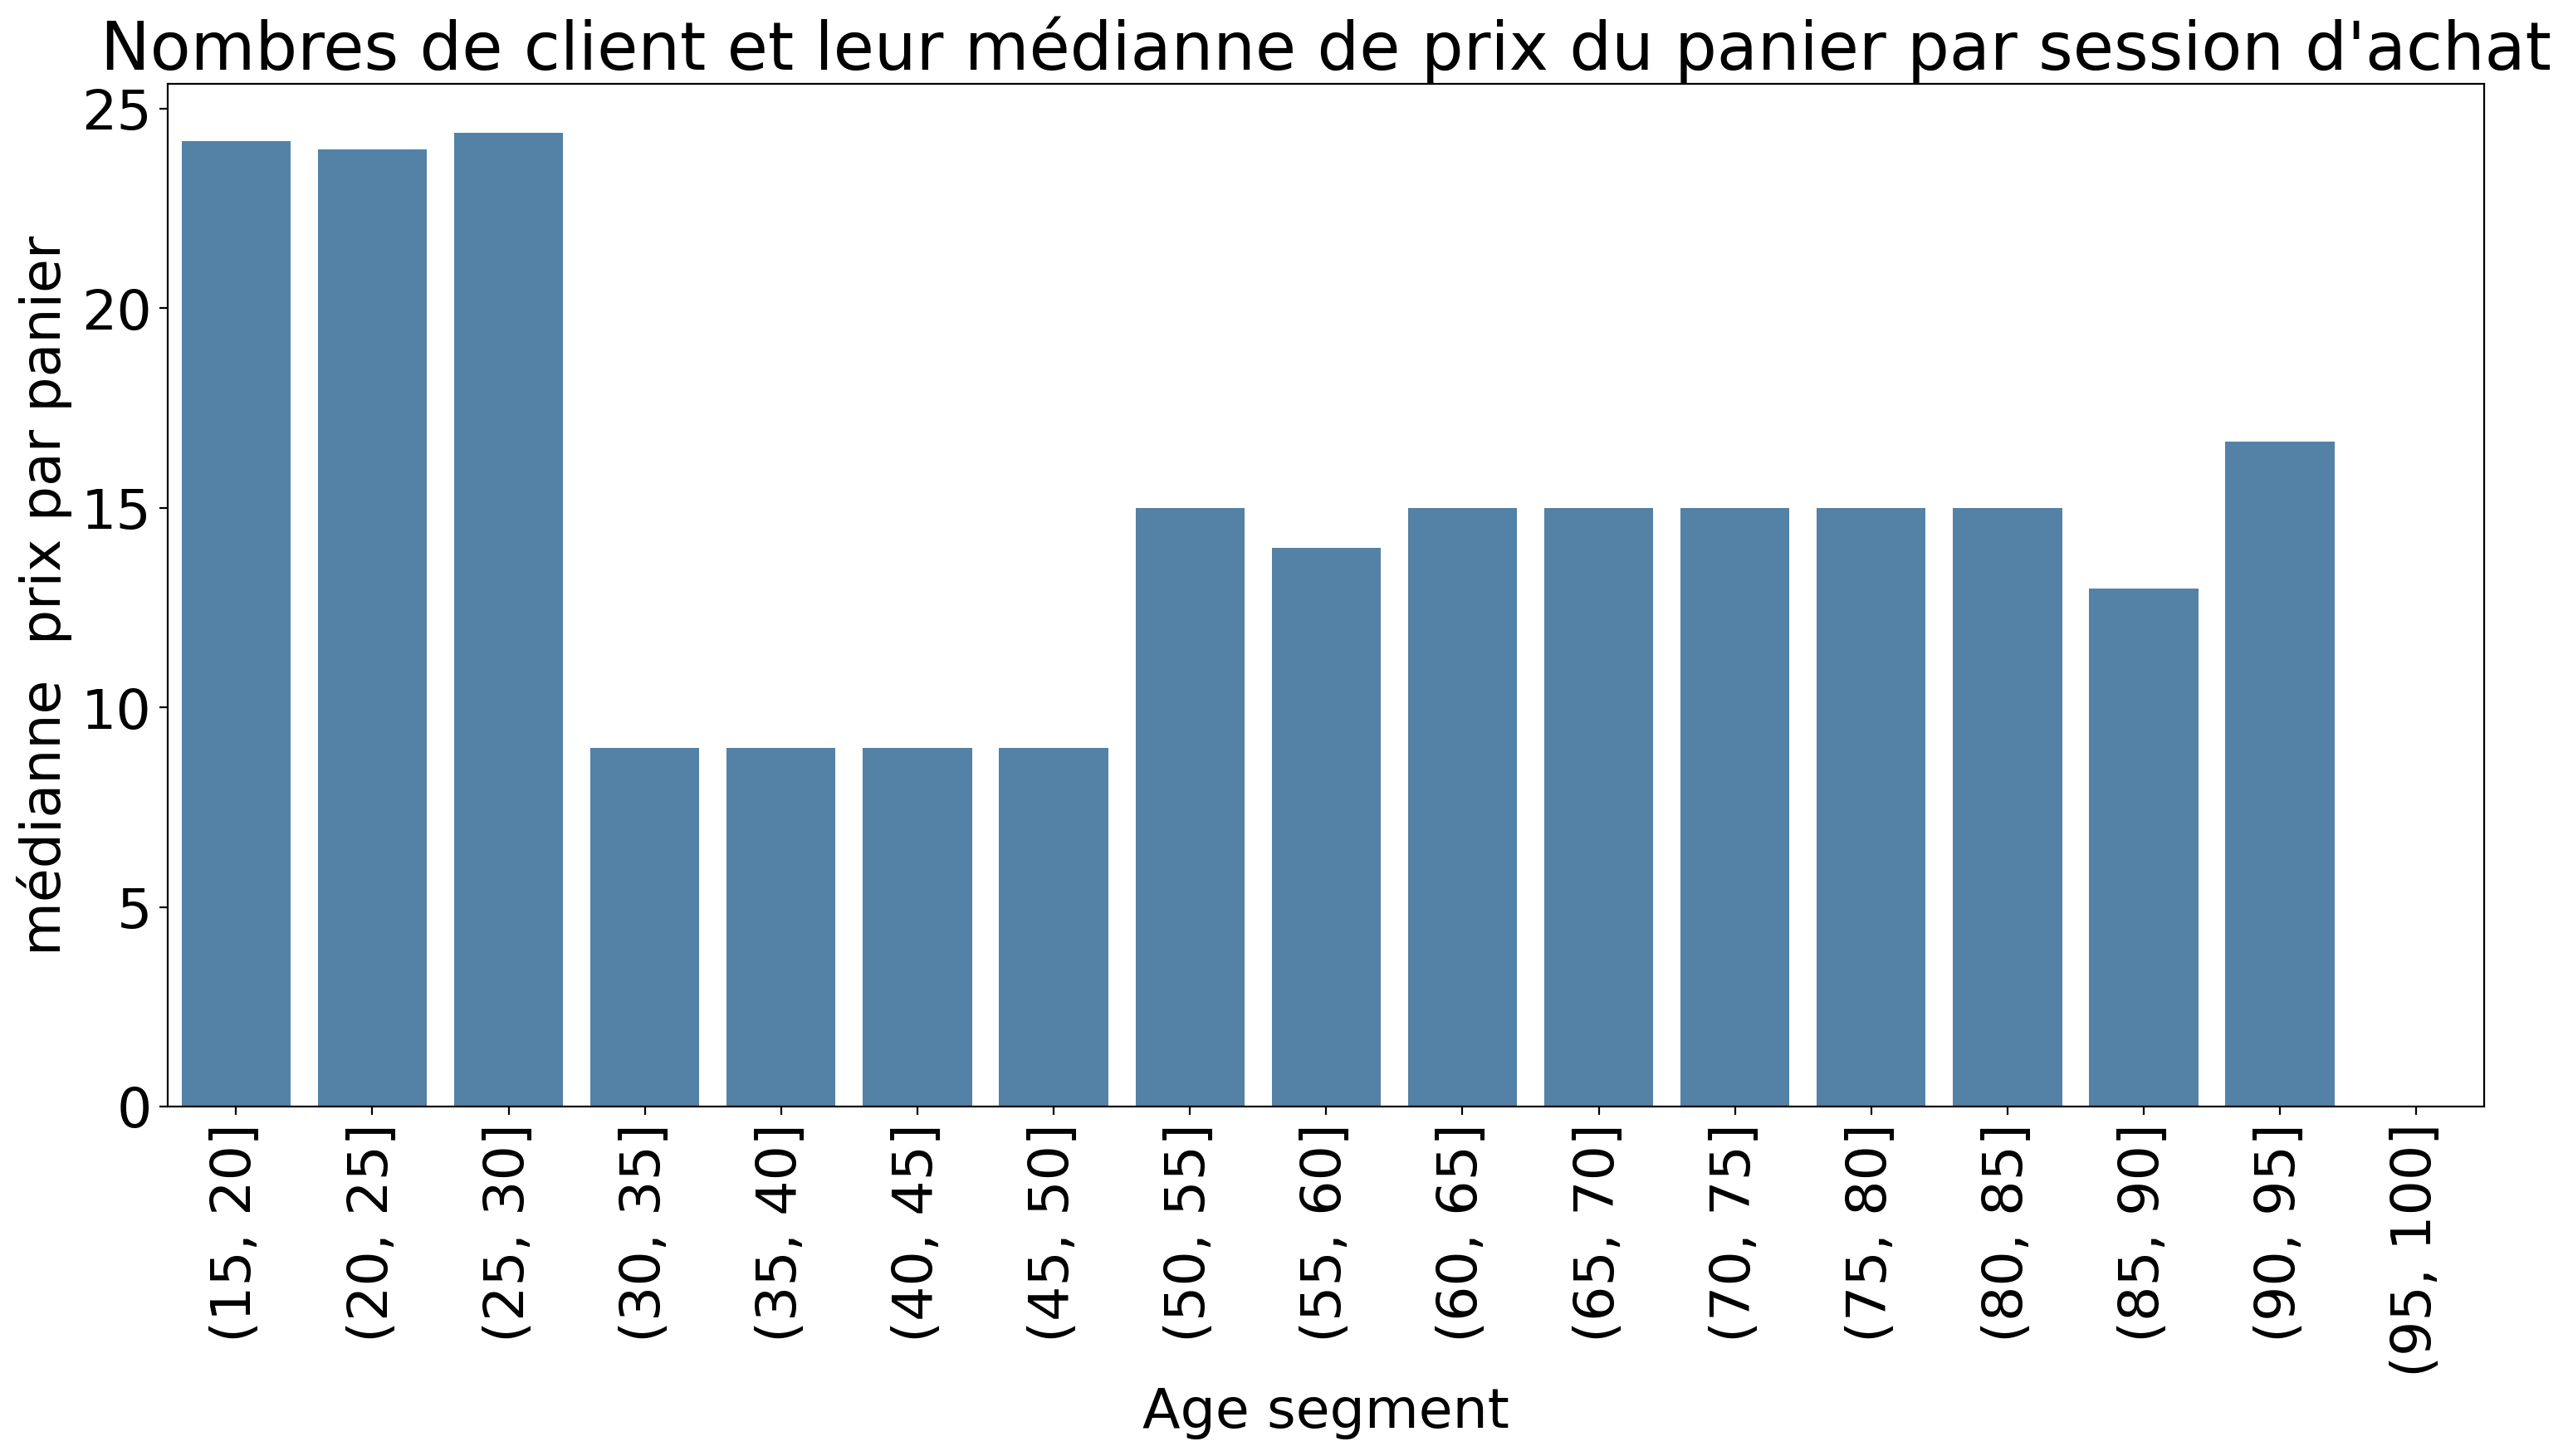

,groupeage,price
0,"(15, 20]",24.195
1,"(20, 25]",23.990
2,"(25, 30]",24.400
3,"(30, 35]",8.990
4,"(35, 40]",8.990
5,"(40, 45]",8.990
6,"(45, 50]",8.990
7,"(50, 55]",14.990
8,"(55, 60]",13.990
9,"(60, 65]",14.990


In [8]:
x = data_librairie_without_imputation.drop_duplicates(subset=['client_id'])
x["groupeage"] = pd.cut(x["age transact"], bins= range(15, 101, 5))  #.group_by("age transact", aggfunc="count")
x2 = x.groupby("groupeage")["price"].agg(np.median)
x3 = x2.reset_index()


plt.style.use('default')
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(18,8), dpi=200)

a = sns.barplot(x=x3["groupeage"], y= x3["price"], 
            data=x3,
            color='steelblue')
plt.xticks(rotation=90)
plt.title("Nombres de client et leur médianne de prix du panier par session d'achat")
plt.ylabel("médianne  prix par panier")
plt.xlabel("Age segment")
plt.savefig('./dataset_P4/nbclient_price_by_session.png')
plt.show()

x3

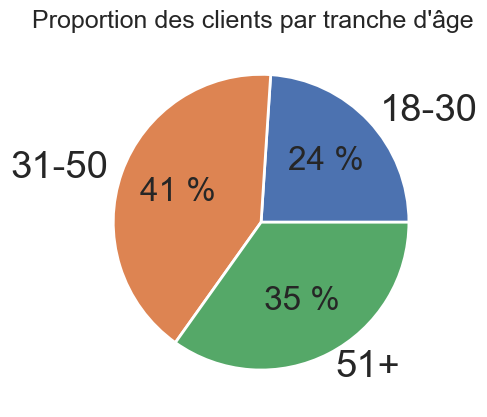

<Figure size 3000x2000 with 0 Axes>

In [75]:
segment_age = data_librairie_without_imputation.drop_duplicates(subset=['client_id']).pivot_table(values="price", index= "age_segment", aggfunc= "count", margins = False).reset_index()


nbclient_segment_age = segment_age["price"].values
nbclient_segment_age

plt.pie(nbclient_segment_age, 
            labels=["18-30","31-50","51+"], 
            autopct=lambda x: str(int(round(x))) + ' %',            
            wedgeprops={'edgecolor' : 'w', 'linewidth' : 2},            
           )

plt.figtext(.5,.9,"Proportion des clients par tranche d'âge", fontsize=18, ha='center')
plt.savefig("./dataset_P4/proportion par tranche d'age.png")
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(15,10), dpi=200)
plt.show()



In [10]:
data_librairie_without_imputation["age_segment"] = np.where(data_librairie_without_imputation["age transact"] < 30, "18-30", (np.where(data_librairie_without_imputation["age transact"] > 50, "51+", "31-50")))
data_librairie_without_imputation





,client_id,total_buy,id_prod,date,session_id,price,categ,sex,birth,age transact,age_segment
0,c_1,301,2_208,2021-11-04 17:28:13.934070,s_114737,54.87,2.0,m,1955,67,51+
1,c_1,301,0_1571,2022-02-01 01:47:04.355850,s_158128,5.99,0.0,m,1955,68,51+
2,c_1,301,1_425,2021-12-25 03:53:43.623598,s_139610,16.99,1.0,m,1955,67,51+
3,c_1,301,1_364,2021-11-15 20:46:25.222740,s_120172,10.30,1.0,m,1955,67,51+
4,c_1,301,1_364,2021-12-15 23:32:41.632729,s_134971,10.30,1.0,m,1955,67,51+
...,...,...,...,...,...,...,...,...,...,...,...
336708,c_999,305,1_669,2022-01-16 23:40:14.387888,s_150872,15.99,1.0,m,1964,59,51+
336709,c_999,305,0_2104,2021-10-02 20:31:58.645109,s_99070,7.98,0.0,m,1964,58,51+
336710,c_999,305,1_247,2022-01-24 09:39:50.831782,s_154462,20.99,1.0,m,1964,59,51+
336711,c_999,305,1_727,2021-11-21 17:40:50.856434,s_122996,16.99,1.0,m,1964,58,51+


### La fréquence d’achat (nombre d'achats par mois ) 
La taille du panier moyen (en nombre d’articles) ;

In [11]:
session_client_date = (data_librairie_without_imputation[["client_id", "date", "session_id"]]).drop_duplicates("session_id", keep='last')

session_client_date["month num"] = (pd.to_datetime(session_client_date["date"])).dt.month.copy()
session_client_date["month text"] = (pd.to_datetime(session_client_date["date"])).dt.month_name().copy()
session_client_date["nb_commande_par_mois"] = 1
session_client_date_trie = (session_client_date.sort_values(by = ["client_id", "month num"]))

nb_commmande_par_mois_client = session_client_date.pivot_table("nb_commande_par_mois", index = "client_id" , columns='month text', aggfunc=sum)                            
nb_commmande_par_mois_client_clean = (nb_commmande_par_mois_client.fillna(0))# .sort_values(axis = 0, by = ['March', 'April', "May", "June", "July", "August", "September", "October", "November", "December", "January", "February"])


nb_commmande_par_mois_client_clean_trier = nb_commmande_par_mois_client_clean[['March', 'April', "May", "June", "July", "August", "September", "October", "November", "December", "January", "February"]]

nb_commmande_par_mois_client_clean_trier["moyenne_nb_achat_par_mois"] = nb_commmande_par_mois_client_clean_trier.mean(axis = 1)
 
Fréq_achat_month = nb_commmande_par_mois_client_clean_trier.reset_index()[["client_id", "moyenne_nb_achat_par_mois"]]
    
Fréq_achat_month.columns    
    
data_librairie_without_imputation = Fréq_achat_month.merge(data_librairie_without_imputation)
data_librairie_without_imputation




<ipython-input-11-9c6b8b186e23>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nb_commmande_par_mois_client_clean_trier["moyenne_nb_achat_par_mois"] = nb_commmande_par_mois_client_clean_trier.mean(axis = 1)


,client_id,moyenne_nb_achat_par_mois,total_buy,id_prod,date,session_id,price,categ,sex,birth,age transact,age_segment
0,c_1,1.25,301,2_208,2021-11-04 17:28:13.934070,s_114737,54.87,2.0,m,1955,67,51+
1,c_1,1.25,301,0_1571,2022-02-01 01:47:04.355850,s_158128,5.99,0.0,m,1955,68,51+
2,c_1,1.25,301,1_425,2021-12-25 03:53:43.623598,s_139610,16.99,1.0,m,1955,67,51+
3,c_1,1.25,301,1_364,2021-11-15 20:46:25.222740,s_120172,10.30,1.0,m,1955,67,51+
4,c_1,1.25,301,1_364,2021-12-15 23:32:41.632729,s_134971,10.30,1.0,m,1955,67,51+
...,...,...,...,...,...,...,...,...,...,...,...,...
336708,c_999,1.75,305,1_669,2022-01-16 23:40:14.387888,s_150872,15.99,1.0,m,1964,59,51+
336709,c_999,1.75,305,0_2104,2021-10-02 20:31:58.645109,s_99070,7.98,0.0,m,1964,58,51+
336710,c_999,1.75,305,1_247,2022-01-24 09:39:50.831782,s_154462,20.99,1.0,m,1964,59,51+
336711,c_999,1.75,305,1_727,2021-11-21 17:40:50.856434,s_122996,16.99,1.0,m,1964,58,51+


### La taille du panier moyen (en nombre d’articles)

In [12]:
nb_prod = (data_librairie_without_imputation[["client_id","session_id"]])

nb_prod["moyenne_nb_prod_par_session"] = 1 

nb_prod_par_session = nb_prod.groupby(by=[ "client_id", 'session_id']).sum().reset_index()

moyenne_nb_prod_par_session = nb_prod_par_session.groupby(by=[ "client_id"]).mean().reset_index()


data_librairie_without_imputation = moyenne_nb_prod_par_session.merge(data_librairie_without_imputation)

data_librairie_without_imputation


<ipython-input-12-4af0686368b0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nb_prod["moyenne_nb_prod_par_session"] = 1


,client_id,moyenne_nb_prod_par_session,moyenne_nb_achat_par_mois,total_buy,id_prod,date,session_id,price,categ,sex,birth,age transact,age_segment
0,c_1,1.333333,1.25,301,2_208,2021-11-04 17:28:13.934070,s_114737,54.87,2.0,m,1955,67,51+
1,c_1,1.333333,1.25,301,0_1571,2022-02-01 01:47:04.355850,s_158128,5.99,0.0,m,1955,68,51+
2,c_1,1.333333,1.25,301,1_425,2021-12-25 03:53:43.623598,s_139610,16.99,1.0,m,1955,67,51+
3,c_1,1.333333,1.25,301,1_364,2021-11-15 20:46:25.222740,s_120172,10.30,1.0,m,1955,67,51+
4,c_1,1.333333,1.25,301,1_364,2021-12-15 23:32:41.632729,s_134971,10.30,1.0,m,1955,67,51+
...,...,...,...,...,...,...,...,...,...,...,...,...,...
336708,c_999,1.047619,1.75,305,1_669,2022-01-16 23:40:14.387888,s_150872,15.99,1.0,m,1964,59,51+
336709,c_999,1.047619,1.75,305,0_2104,2021-10-02 20:31:58.645109,s_99070,7.98,0.0,m,1964,58,51+
336710,c_999,1.047619,1.75,305,1_247,2022-01-24 09:39:50.831782,s_154462,20.99,1.0,m,1964,59,51+
336711,c_999,1.047619,1.75,305,1_727,2021-11-21 17:40:50.856434,s_122996,16.99,1.0,m,1964,58,51+


In [13]:
# transformation de toutes les données en float :
data_librairie_without_imputation["age_segment"] = np.where(data_librairie_without_imputation["age transact"] < 30, "18-30", (np.where(data_librairie_without_imputation["age transact"] > 50, "51+", "31-50")))
data_librairie_all_float = data_librairie_without_imputation
data_librairie_all_float["id_prod"] =pd.to_numeric(data_librairie_all_float["id_prod"].str[2:])
data_librairie_all_float["session_id"] = pd.to_numeric(data_librairie_all_float["session_id"].str[2:])
data_librairie_all_float["client_id"] = pd.to_numeric(data_librairie_all_float["client_id"].str[2:])
data_librairie_all_float["sex"] = pd.to_numeric((data_librairie_all_float['sex']).map({'m' : 1,'f' : 0}))
data_librairie_all_float["date"] = pd.to_numeric(data_librairie_all_float["date"].str[5:7])
data_librairie_all_float["date"] = np.where(data_librairie_all_float["date"] <= 2, (data_librairie_all_float["date"]+12),data_librairie_all_float["date"])

data_librairie_all_float["age_segment"] = pd.to_numeric(np.where(data_librairie_all_float["age transact"] < 30, 0, (np.where(data_librairie_all_float["age transact"] > 50, 2, 1))))
    


# transformer initilization
transformer = StandardScaler()

data_librairie_without_imputation_array = np.array(data_librairie_without_imputation)

# transformed matrix
data_librairie_without_imputation_array = transformer.fit_transform(data_librairie_all_float)




# transactions_array = np.array(transactions_normalized)
pd.DataFrame(data_librairie_without_imputation_array, columns=data_librairie_all_float.columns).describe()

heatmap_data_librairie = pd.DataFrame(data_librairie_without_imputation, columns=data_librairie_all_float.columns)
heatmap_data_librairie_clean = heatmap_data_librairie.drop(['session_id', 'client_id', "id_prod", "birth", "age_segment"], axis=1)

heatmap_data_librairie_clean

,moyenne_nb_prod_par_session,moyenne_nb_achat_par_mois,total_buy,date,price,categ,sex,age transact
0,1.333333,1.25,301,11,54.87,2.0,1,67
1,1.333333,1.25,301,14,5.99,0.0,1,68
2,1.333333,1.25,301,12,16.99,1.0,1,67
3,1.333333,1.25,301,11,10.30,1.0,1,67
4,1.333333,1.25,301,12,10.30,1.0,1,67
...,...,...,...,...,...,...,...,...
336708,1.047619,1.75,305,13,15.99,1.0,1,59
336709,1.047619,1.75,305,10,7.98,0.0,1,58
336710,1.047619,1.75,305,13,20.99,1.0,1,59
336711,1.047619,1.75,305,11,16.99,1.0,1,58


## coefficient de corrélation

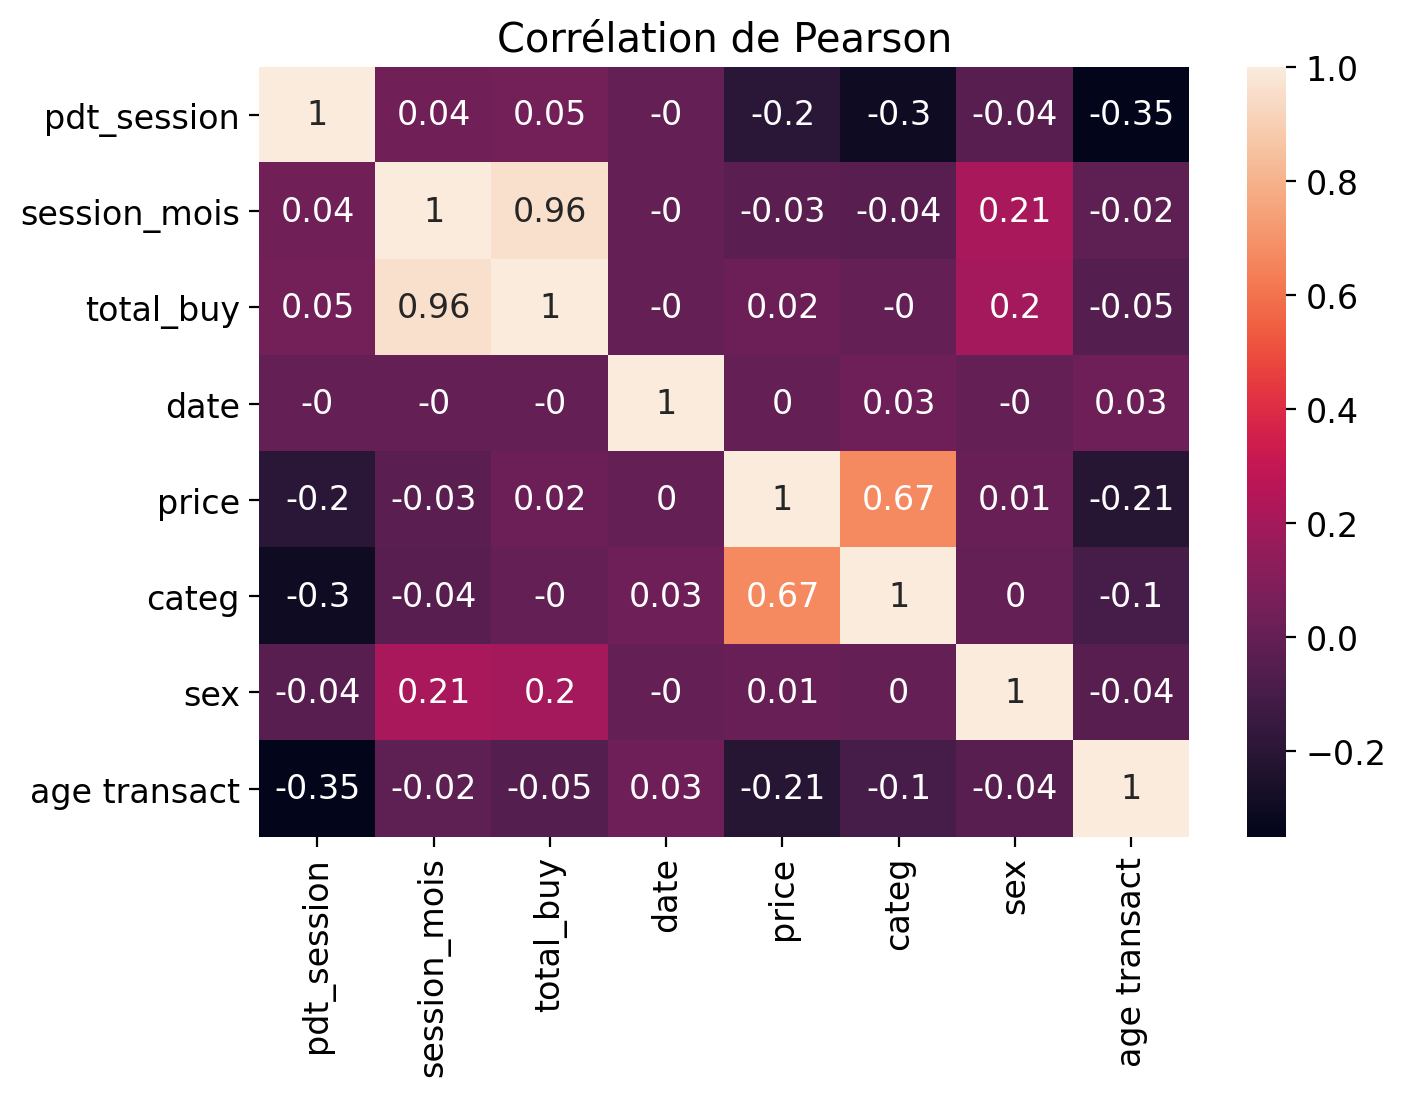

In [14]:
heatmap_data_librairie_clean2 = heatmap_data_librairie_clean.rename(columns={"moyenne_nb_prod_par_session": "pdt_session", "moyenne_nb_achat_par_mois": "session_mois"})

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(7.5,5), dpi=200)
plt.xticks(rotation=61)
plt.title("Corrélation de Pearson")
sns.heatmap(((heatmap_data_librairie_clean2.corr())).round(2), annot=True);  # coefficient de pearson
plt.savefig('./dataset_P4/Pearson.png')

## Coefficient de determination (R²)

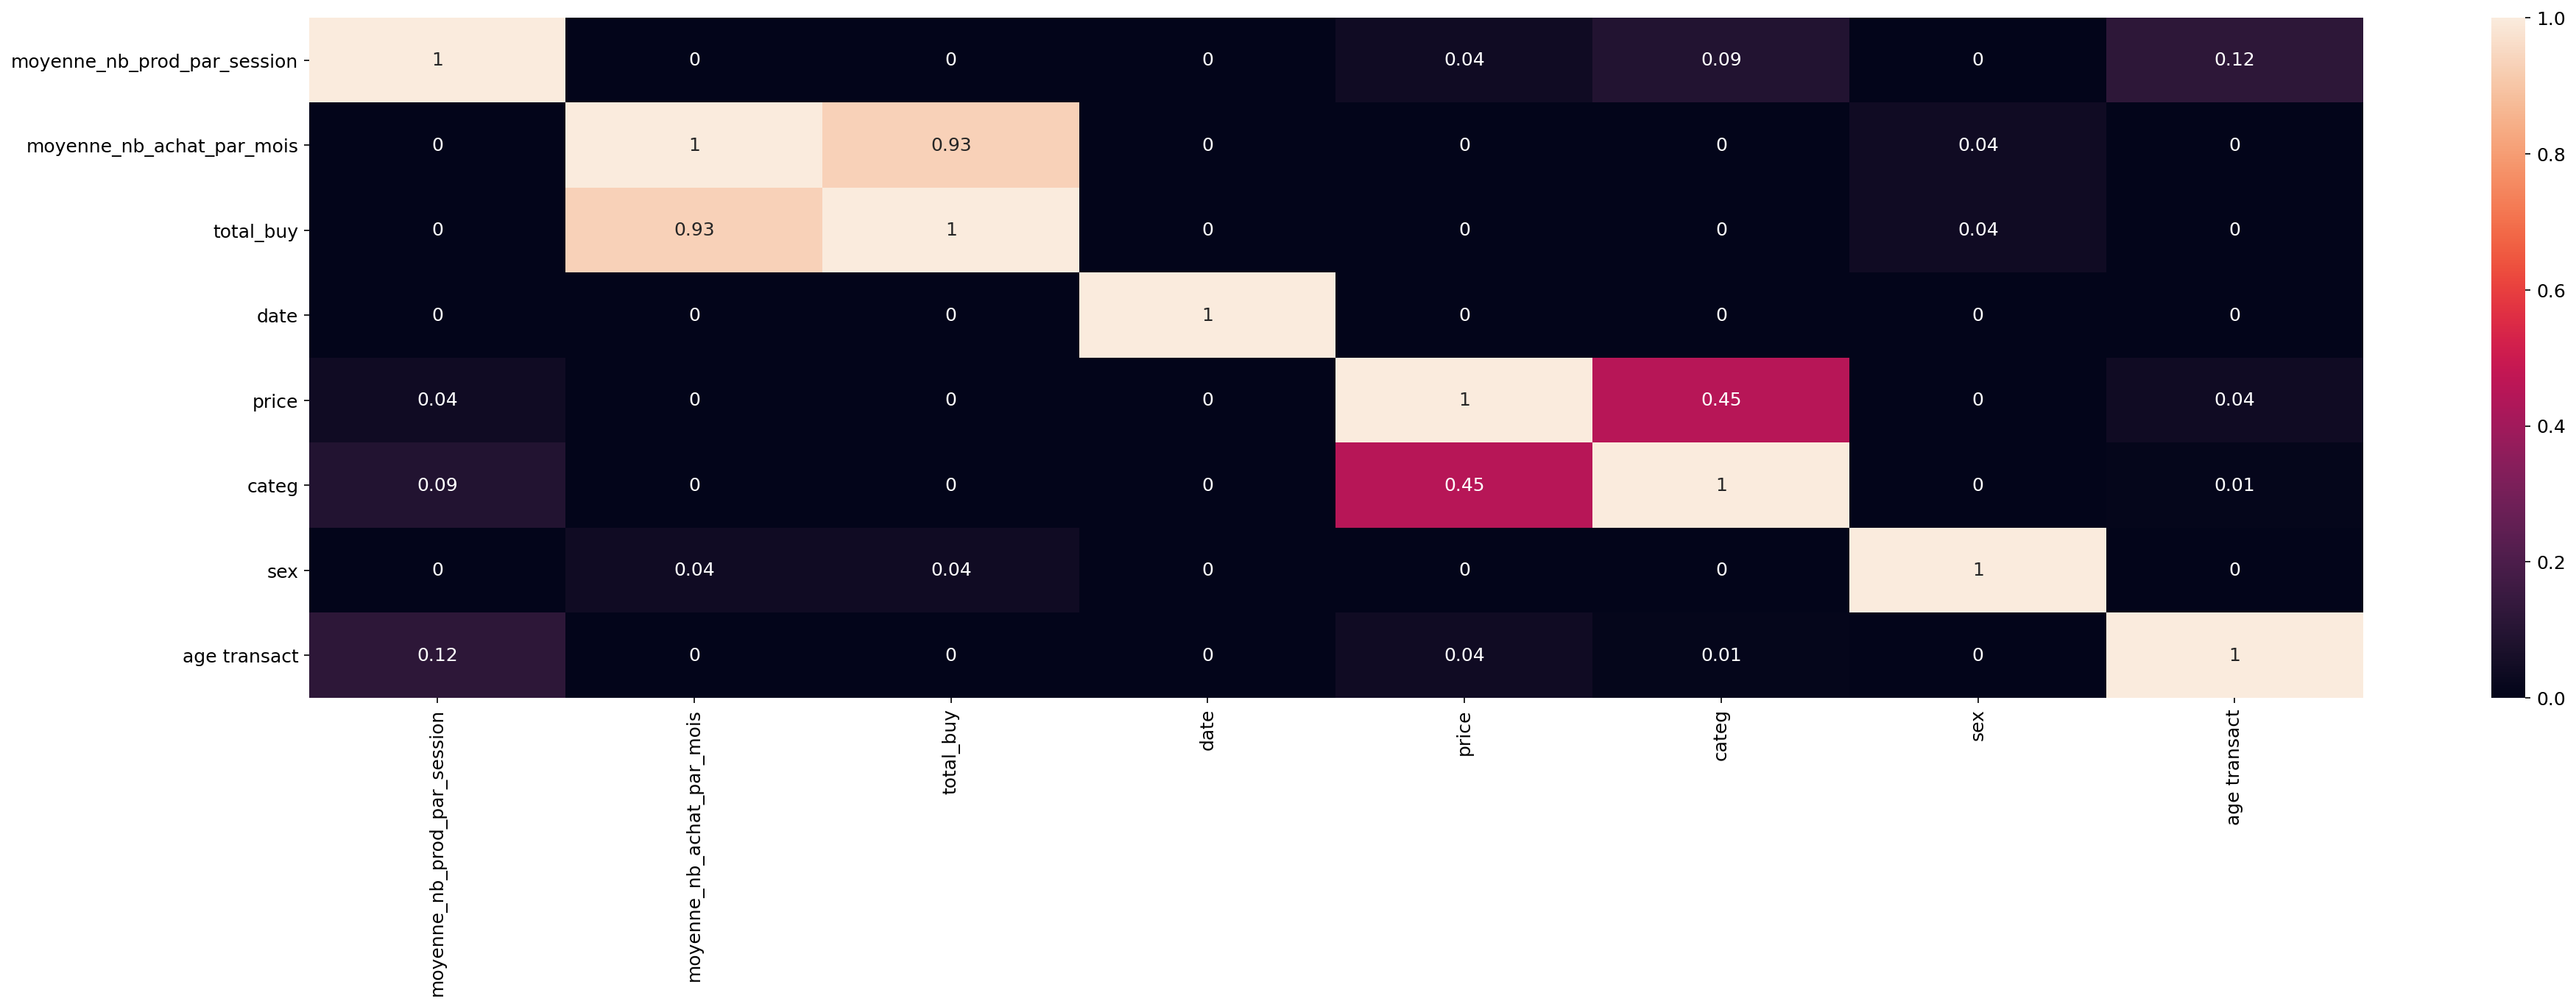

In [15]:
plt.figure(dpi=150, figsize=(30,8))
sns.heatmap(((heatmap_data_librairie_clean.corr())**2).round(2), annot=True);

# Analyse relation entre le sexe et les catégories de produits achetés
## transformation du sexe en booléen 

In [16]:
data_librairie_without_imputation["male"] = data_librairie_without_imputation["sex"]

# pd.to_numeric((data_librairie_without_imputation['sex']).map({'m' : 1,'f' : 0}))


sex_categ = data_librairie_without_imputation
khi2_eta2_sex_categ = sex_categ[["male", "categ"]]
sex_categ["sex"].nunique()

2

## analyse Khi-2 et eta2

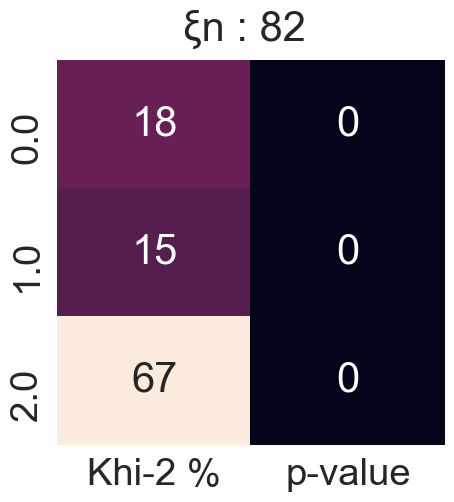

Khi-2 théorique de 4,6050 (ddl: 2 , alpha: 10%)


F:\w10\Programme\Anaconda\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
F:\w10\Programme\Anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


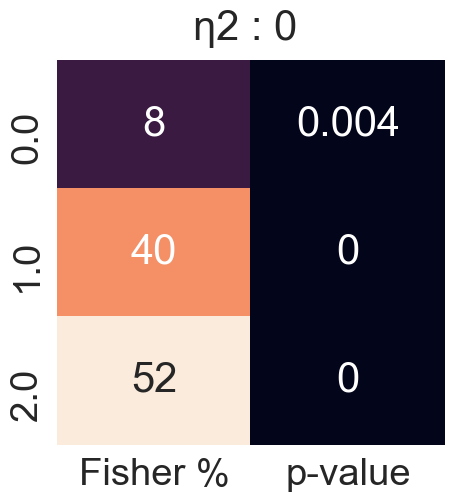

,client_id,moyenne_nb_prod_par_session,moyenne_nb_achat_par_mois,total_buy,id_prod,date,session_id,price,categ,sex,birth,age transact,age_segment,male
0,1,1.333333,1.25,301,208,11,114737,54.87,2.0,1,1955,67,2,1
1,1,1.333333,1.25,301,1571,14,158128,5.99,0.0,1,1955,68,2,1
2,1,1.333333,1.25,301,425,12,139610,16.99,1.0,1,1955,67,2,1
3,1,1.333333,1.25,301,364,11,120172,10.30,1.0,1,1955,67,2,1
4,1,1.333333,1.25,301,364,12,134971,10.30,1.0,1,1955,67,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336708,999,1.047619,1.75,305,669,13,150872,15.99,1.0,1,1964,59,2,1
336709,999,1.047619,1.75,305,2104,10,99070,7.98,0.0,1,1964,58,2,1
336710,999,1.047619,1.75,305,247,13,154462,20.99,1.0,1,1964,59,2,1
336711,999,1.047619,1.75,305,727,11,122996,16.99,1.0,1,1964,58,2,1


In [17]:
chi2('male','categ', sex_categ)
print("Khi-2 théorique de 4,6050 (ddl: 2 , alpha: 10%)")
eta2('male','categ', sex_categ)
data_librairie_without_imputation



In [18]:
contigence = data_librairie_without_imputation.pivot_table(values="price", index= "sex", columns= "categ", aggfunc= "count", margins = True)
contigence

categ,0.0,1.0,2.0,All
sex,,,,
0,103786,55469,8260,167515
1,105640,54266,9292,169198
All,209426,109735,17552,336713


In [19]:
contigence_categ = contigence.values[-1][:-1]
x = contigence_categ.reshape(1,-1)
x

array([[209426, 109735,  17552]], dtype=int64)

In [20]:
contigence_sex = contigence["All"].values[:-1]
y = contigence_sex.reshape(1,-1)
y

array([[167515, 169198]], dtype=int64)

In [21]:
zh = np.dot(y.T , x)/(contigence.values[-1][-1])
zh

array([[104189.61070704,  54593.25456695,   8732.13472601],
       [105236.38929296,  55141.74543305,   8819.86527399]])

In [22]:
zr = data_librairie_without_imputation.pivot_table(values="price", index = "sex", columns= "categ", aggfunc= "count").values
zr

array([[103786,  55469,   8260],
       [105640,  54266,   9292]], dtype=int64)

In [23]:
Khi2 = ((zr-zh)**2/zr).sum() #=82
# 9,21
Khi2

from scipy.stats import chi2
chi2.pdf(Khi2, df= 2)
# rejet de l'hypothése nul (rejet de l'indépendance des variable)

7.6324537121416745e-19

## Analyse de la proportion de nombre de produit vendu par catégorie par genre



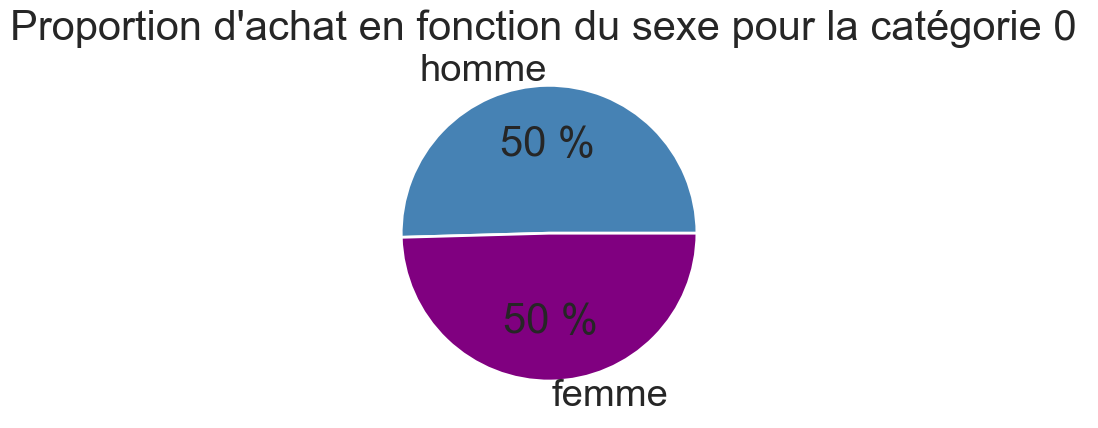

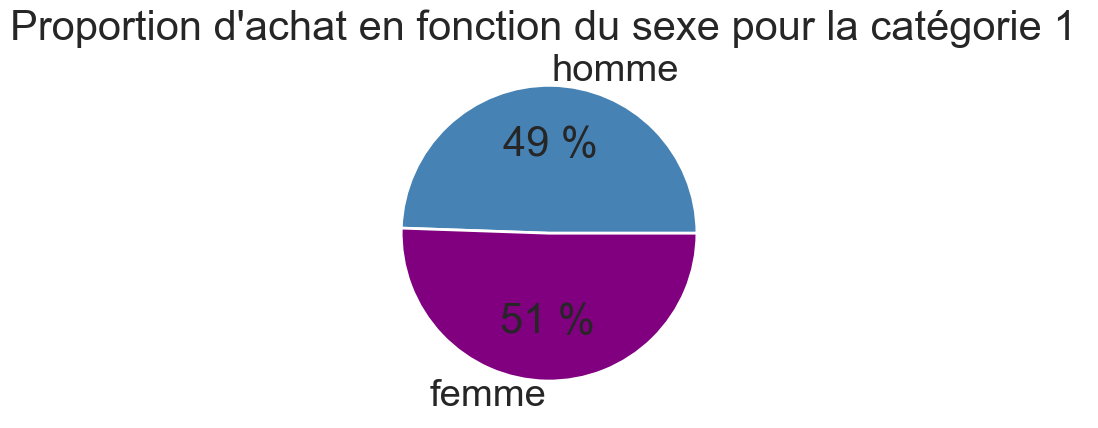

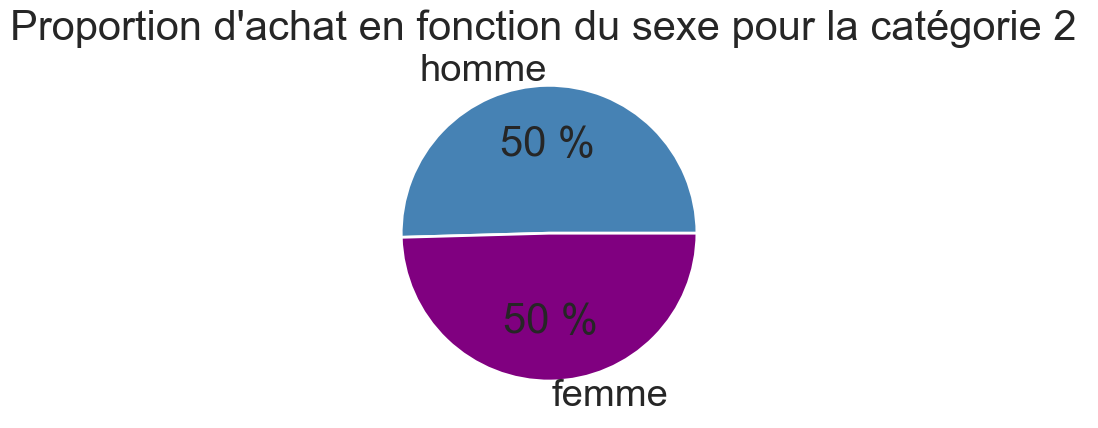

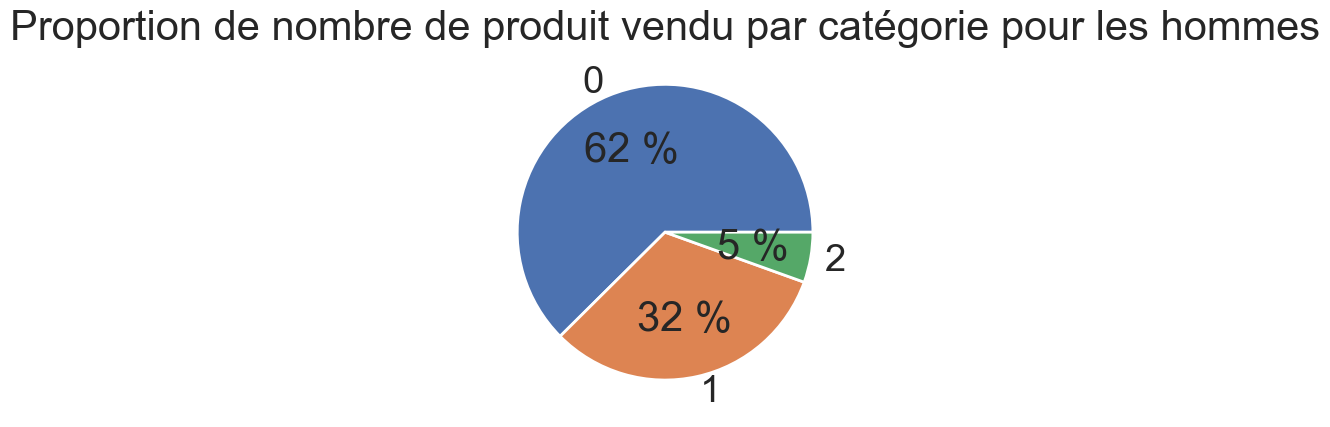

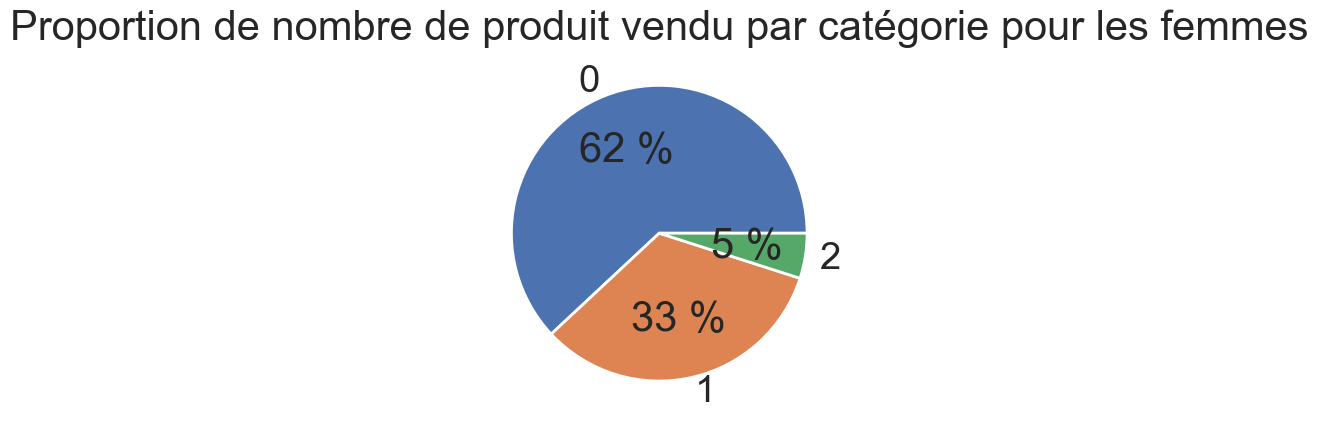

In [24]:
male_categ0 = ((sex_categ[(sex_categ["categ"] == 0) & (sex_categ["male"] == 1)])["id_prod"].value_counts()).sum()
female_categ0 = ((sex_categ[(sex_categ["categ"] == 0) & (sex_categ["male"] == 0)])["id_prod"].value_counts()).sum()
sex_par_categ0 = [male_categ0, female_categ0]


plt.pie(sex_par_categ0, 
            labels=["homme","femme"], 
            autopct=lambda x: str(int(round(x))) + ' %',  
            wedgeprops={'edgecolor' : 'w', 'linewidth' : 2},  
            colors = ['steelblue', 'purple']
           )
plt.title("Proportion d'achat en fonction du sexe pour la catégorie 0 ")

plt.show()


male_categ1 = ((sex_categ[(sex_categ["categ"] == 1) & (sex_categ["male"] == 1)])["id_prod"].value_counts()).sum()
female_categ1 = ((sex_categ[(sex_categ["categ"] == 1) & (sex_categ["male"] == 0)])["id_prod"].value_counts()).sum()
sex_par_categ1 = [male_categ1, female_categ1]


plt.pie(sex_par_categ1, 
            labels=["homme","femme"], 
            autopct=lambda x: str(int(round(x))) + ' %',  
            wedgeprops={'edgecolor' : 'w', 'linewidth' : 2}, 
            colors = ['steelblue', 'purple']
           )
plt.title("Proportion d'achat en fonction du sexe pour la catégorie 1 ")

plt.show()


male_categ2 = ((sex_categ[(sex_categ["categ"] == 2) & (sex_categ["male"] == 1)])["id_prod"].value_counts()).sum()
female_categ2 = ((sex_categ[(sex_categ["categ"] == 2) & (sex_categ["male"] == 0)])["id_prod"].value_counts()).sum()
sex_par_categ2= [male_categ0, female_categ0]


plt.pie(sex_par_categ2, 
            labels=["homme","femme"], 
            autopct=lambda x: str(int(round(x))) + ' %',  
            wedgeprops={'edgecolor' : 'w', 'linewidth' : 2},
            colors = ['steelblue', 'purple']
           )
plt.title("Proportion d'achat en fonction du sexe pour la catégorie 2 ")

plt.show()



male_categ0 = ((sex_categ[(sex_categ["categ"] == 0) & (sex_categ["male"] == 1)])["id_prod"].value_counts()).sum()
male_categ1 = ((sex_categ[(sex_categ["categ"] == 1) & (sex_categ["male"] == 1)])["id_prod"].value_counts()).sum()
nmale_categ2 = ((sex_categ[(sex_categ["categ"] == 2) & (sex_categ["male"] == 1)])["id_prod"].value_counts()).sum()
male_par_categ= [male_categ0, male_categ1, male_categ2]


plt.pie(male_par_categ, 
            labels=[0,1,2], 
            autopct=lambda x: str(int(round(x))) + ' %',  
            wedgeprops={'edgecolor' : 'w', 'linewidth' : 2},            
           )
plt.title("Proportion de nombre de produit vendu par catégorie pour les hommes")

plt.show()

female_categ0 = ((sex_categ[(sex_categ["categ"] == 0) & (sex_categ["male"] == 0)])["id_prod"].value_counts()).sum()
female_categ1 = ((sex_categ[(sex_categ["categ"] == 1) & (sex_categ["male"] == 0)])["id_prod"].value_counts()).sum()
female_categ2 = ((sex_categ[(sex_categ["categ"] == 2) & (sex_categ["male"] == 0)])["id_prod"].value_counts()).sum()
female_par_categ= [female_categ0, female_categ1, female_categ2]


plt.pie(female_par_categ, 
            labels=[0,1,2], 
            autopct=lambda x: str(int(round(x))) + ' %',  
            wedgeprops={'edgecolor' : 'w', 'linewidth' : 2},            
           )
plt.title("Proportion de nombre de produit vendu par catégorie pour les femmes")

plt.show()

## Analyse des produits les plus acheter par genre

In [25]:
sex_categ["achat_par_genre"]  =     np.where(sex_categ["male"] == 1, 1, -1)


sex_categ_genre = sex_categ.pivot_table("achat_par_genre", index = "id_prod", aggfunc= sum)

sex_categ_genre["achat_par_genre"].sort_values(ascending = False).dropna().head(20)
sex_categ_genre["achat_par_genre"].sort_values(ascending = True).dropna().head(20)

id_prod
392    -70
347    -58
1607   -52
301    -48
256    -48
1030   -47
366    -47
413    -45
1351   -44
311    -43
320    -41
389    -40
480    -40
1      -39
313    -39
1451   -38
407    -38
457    -37
246    -37
493    -37
Name: achat_par_genre, dtype: int32

In [26]:
sex_categ_clean = sex_categ[["sex", "categ", "id_prod", "achat_par_genre"]]
pdt_male20 = sex_categ_clean.pivot_table("achat_par_genre", index = ["categ", "id_prod"], aggfunc= sum).sort_values(by = "achat_par_genre", ascending = False).iloc[1:327].reset_index()



pdt_female20 = sex_categ_clean.pivot_table("achat_par_genre", index = ["categ", "id_prod"], aggfunc= sum).sort_values(by = "achat_par_genre", ascending = True).iloc[1:327].reset_index()


pdt_male20_categ0 = ((pdt_male20[(pdt_male20["categ"] == 0)])["id_prod"].value_counts()).sum()
pdt_male20_categ1 = ((pdt_male20[(pdt_male20["categ"] == 1)])["id_prod"].value_counts()).sum()
pdt_male20_categ2 = ((pdt_male20[(pdt_male20["categ"] == 2) ])["id_prod"].value_counts()).sum()
pdt_male20_par_categ= [pdt_male20_categ0, pdt_male20_categ1, pdt_male20_categ2]

pdt_female20_categ0 = ((pdt_female20[(pdt_female20["categ"] == 0)])["id_prod"].value_counts()).sum()
pdt_female20_categ1 = ((pdt_female20[(pdt_female20["categ"] == 1)])["id_prod"].value_counts()).sum()
pdt_female20_categ2 = ((pdt_female20[(pdt_female20["categ"] == 2) ])["id_prod"].value_counts()).sum()
pdt_female20_par_categ= [pdt_female20_categ0, pdt_female20_categ1, pdt_female20_categ2]
pdt_female20

,categ,id_prod,achat_par_genre
0,1.0,347,-55
1,0.0,1607,-52
2,0.0,1030,-47
3,0.0,1,-45
4,1.0,256,-45
...,...,...,...
321,0.0,2307,-9
322,0.0,1673,-9
323,1.0,737,-9
324,1.0,738,-9


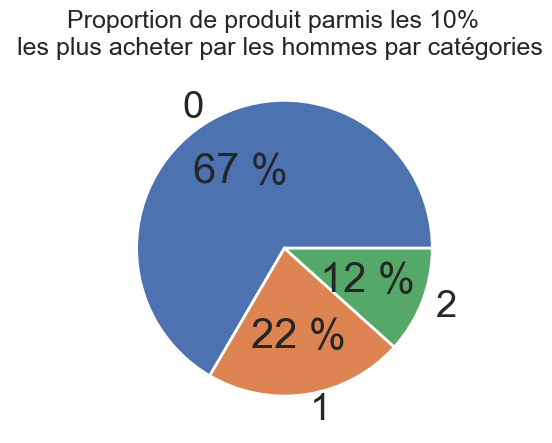

<Figure size 3000x2000 with 0 Axes>

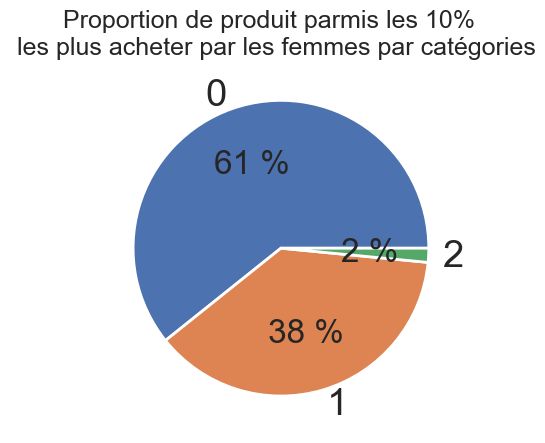

<Figure size 6000x4000 with 0 Axes>

In [27]:


plt.pie(pdt_male20_par_categ, 
            labels=[0,1,2], 
            autopct=lambda x: str(int(round(x))) + ' %',  
            wedgeprops={'edgecolor' : 'w', 'linewidth' : 2},            
           )

plt.figtext(.5,.9,'Proportion de produit parmis les 10% \n les plus acheter par les hommes par catégories', fontsize=18, ha='center')
plt.savefig('./dataset_P4/categ_homme10%.png')
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(15,10), dpi=200)
plt.show()


plt.pie(pdt_female20_par_categ, 
            labels=[0,1,2], 
            autopct=lambda x: str(int(round(x))) + ' %',  
            wedgeprops={'edgecolor' : 'w', 'linewidth' : 2},            
           )
plt.figtext(.5,.9,'Proportion de produit parmis les 10% \n les plus acheter par les femmes par catégories', fontsize=18, ha='center')
plt.savefig('./dataset_P4/categ_femme10%.png')
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(30,20), dpi=200)
plt.show()

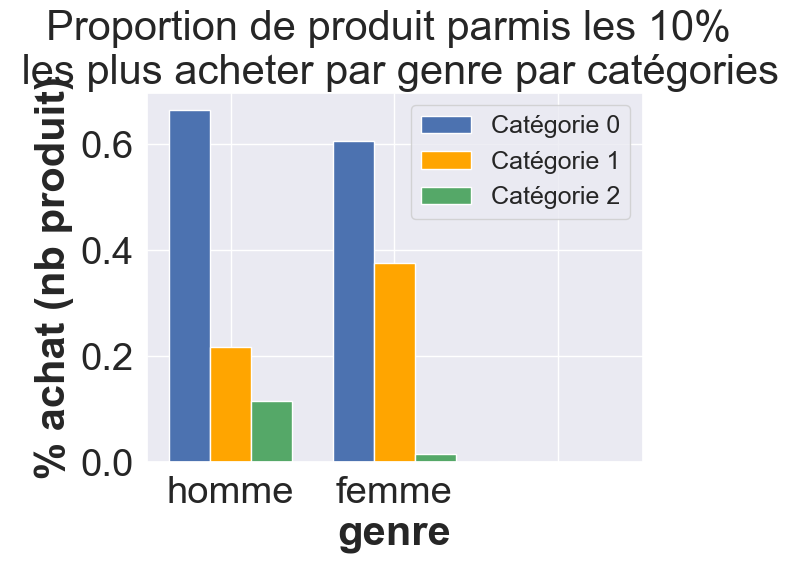

<Figure size 6000x4000 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [28]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bars
barWidth = 0.25

pdt_male20_categ0_pour100 = (((pdt_male20[(pdt_male20["categ"] == 0)])["id_prod"].value_counts()).sum())/327
pdt_male20_categ1_pour100 = (((pdt_male20[(pdt_male20["categ"] == 1)])["id_prod"].value_counts()).sum())/327
pdt_male20_categ2_pour100 = (((pdt_male20[(pdt_male20["categ"] == 2) ])["id_prod"].value_counts()).sum())/327


pdt_female20_categ0_pour100 = (((pdt_female20[(pdt_female20["categ"] == 0)])["id_prod"].value_counts()).sum())/327
pdt_female20_categ1_pour100 = (((pdt_female20[(pdt_female20["categ"] == 1)])["id_prod"].value_counts()).sum())/327
pdt_female20_categ2_pour100 = (((pdt_female20[(pdt_female20["categ"] == 2) ])["id_prod"].value_counts()).sum())/327

pdt_categ0= [pdt_male20_categ0_pour100, pdt_female20_categ0_pour100, 0]
pdt_categ1= [pdt_male20_categ1_pour100, pdt_female20_categ1_pour100, 0]
pdt_categ2= [pdt_male20_categ2_pour100, pdt_female20_categ2_pour100, 0]

 
bars1 = pdt_categ0
bars2 = pdt_categ1
bars3 = pdt_categ2
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
plt.title("Proportion de produit parmis les 10% \n les plus acheter par genre par catégories")

# Make the plot
plt.bar(r1, bars1, color='b', width=barWidth, edgecolor='white', label='Catégorie 0')
plt.bar(r2, bars2, color='orange', width=barWidth, edgecolor='white', label='Catégorie 1')
plt.bar(r3, bars3, color='g', width=barWidth, edgecolor='white', label='Catégorie 2')
 
# Add xticks on the middle of the group bars
plt.xlabel('genre', fontweight='bold')
plt.ylabel("% achat (nb produit)", fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['homme', 'femme', ""])
 
# Create legend & Show graphic
plt.legend(loc = "upper right", fontsize =18)
plt.figure(figsize=(30,20), dpi=200)

plt.show()
plt.savefig('./dataset_P4/categ_genre10%.png')


In [29]:
data_librairie_without_imputation

,client_id,moyenne_nb_prod_par_session,moyenne_nb_achat_par_mois,total_buy,id_prod,date,session_id,price,categ,sex,birth,age transact,age_segment,male,achat_par_genre
0,1,1.333333,1.25,301,208,11,114737,54.87,2.0,1,1955,67,2,1,1
1,1,1.333333,1.25,301,1571,14,158128,5.99,0.0,1,1955,68,2,1,1
2,1,1.333333,1.25,301,425,12,139610,16.99,1.0,1,1955,67,2,1,1
3,1,1.333333,1.25,301,364,11,120172,10.30,1.0,1,1955,67,2,1,1
4,1,1.333333,1.25,301,364,12,134971,10.30,1.0,1,1955,67,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336708,999,1.047619,1.75,305,669,13,150872,15.99,1.0,1,1964,59,2,1,1
336709,999,1.047619,1.75,305,2104,10,99070,7.98,0.0,1,1964,58,2,1,1
336710,999,1.047619,1.75,305,247,13,154462,20.99,1.0,1,1964,59,2,1,1
336711,999,1.047619,1.75,305,727,11,122996,16.99,1.0,1,1964,58,2,1,1


F:\w10\Programme\Anaconda\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


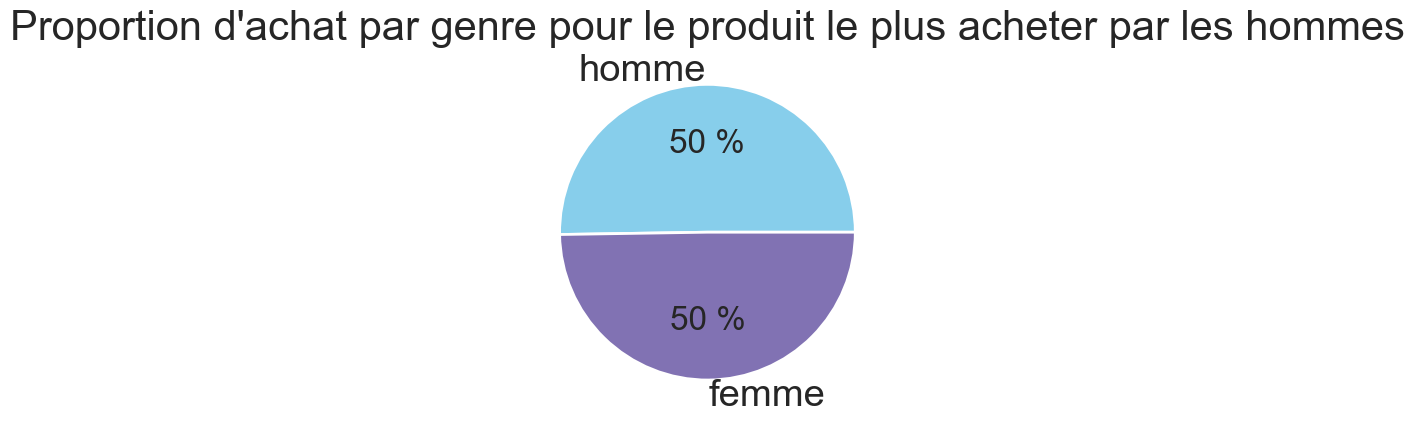

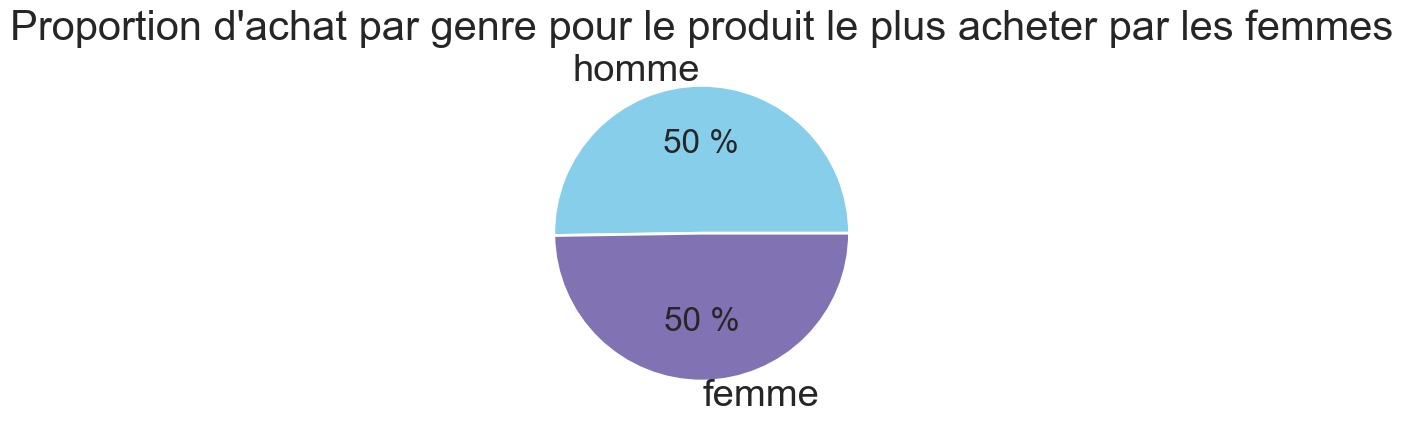

In [30]:
produit_male = sex_categ[sex_categ["id_prod"] == "2_109"]   



produit_male_male =  (sex_categ[(sex_categ["male"] == 1)]["id_prod"].value_counts()).sum()
produit_male_female = (sex_categ[(sex_categ["male"] == 0)]["id_prod"].value_counts()).sum()
produit_male_ratio = [produit_male_male, produit_male_female]


plt.pie(produit_male_ratio, 
            labels=["homme", "femme"], 
            autopct=lambda x: str(int(round(x))) + ' %',  
            wedgeprops={'edgecolor' : 'w', 'linewidth' : 2},
            colors = ['skyblue', 'm']
           )
plt.title("Proportion d'achat par genre pour le produit le plus acheter par les hommes")

plt.show()


produit_male = sex_categ[sex_categ["id_prod"] == "1_392"]   



produit_female_male =  (sex_categ[(sex_categ["male"] == 1)]["id_prod"].value_counts()).sum()
produit_female_female = (sex_categ[(sex_categ["male"] == 0)]["id_prod"].value_counts()).sum()
produit_female_ratio = [produit_female_male, produit_female_female]


plt.pie(produit_female_ratio, 
            labels=["homme", "femme"], 
            autopct=lambda x: str(int(round(x))) + ' %',  
            wedgeprops={'edgecolor' : 'w', 'linewidth' : 2},   
            colors = ['skyblue', 'm']
           )
plt.title("Proportion d'achat par genre pour le produit le plus acheter par les femmes")

plt.show()

In [31]:
# sex_categ
data_librairie_without_imputation

,client_id,moyenne_nb_prod_par_session,moyenne_nb_achat_par_mois,total_buy,id_prod,date,session_id,price,categ,sex,birth,age transact,age_segment,male,achat_par_genre
0,1,1.333333,1.25,301,208,11,114737,54.87,2.0,1,1955,67,2,1,1
1,1,1.333333,1.25,301,1571,14,158128,5.99,0.0,1,1955,68,2,1,1
2,1,1.333333,1.25,301,425,12,139610,16.99,1.0,1,1955,67,2,1,1
3,1,1.333333,1.25,301,364,11,120172,10.30,1.0,1,1955,67,2,1,1
4,1,1.333333,1.25,301,364,12,134971,10.30,1.0,1,1955,67,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336708,999,1.047619,1.75,305,669,13,150872,15.99,1.0,1,1964,59,2,1,1
336709,999,1.047619,1.75,305,2104,10,99070,7.98,0.0,1,1964,58,2,1,1
336710,999,1.047619,1.75,305,247,13,154462,20.99,1.0,1,1964,59,2,1,1
336711,999,1.047619,1.75,305,727,11,122996,16.99,1.0,1,1964,58,2,1,1


# Analyse corrélation entre l'âge des clients et le montant total des achats

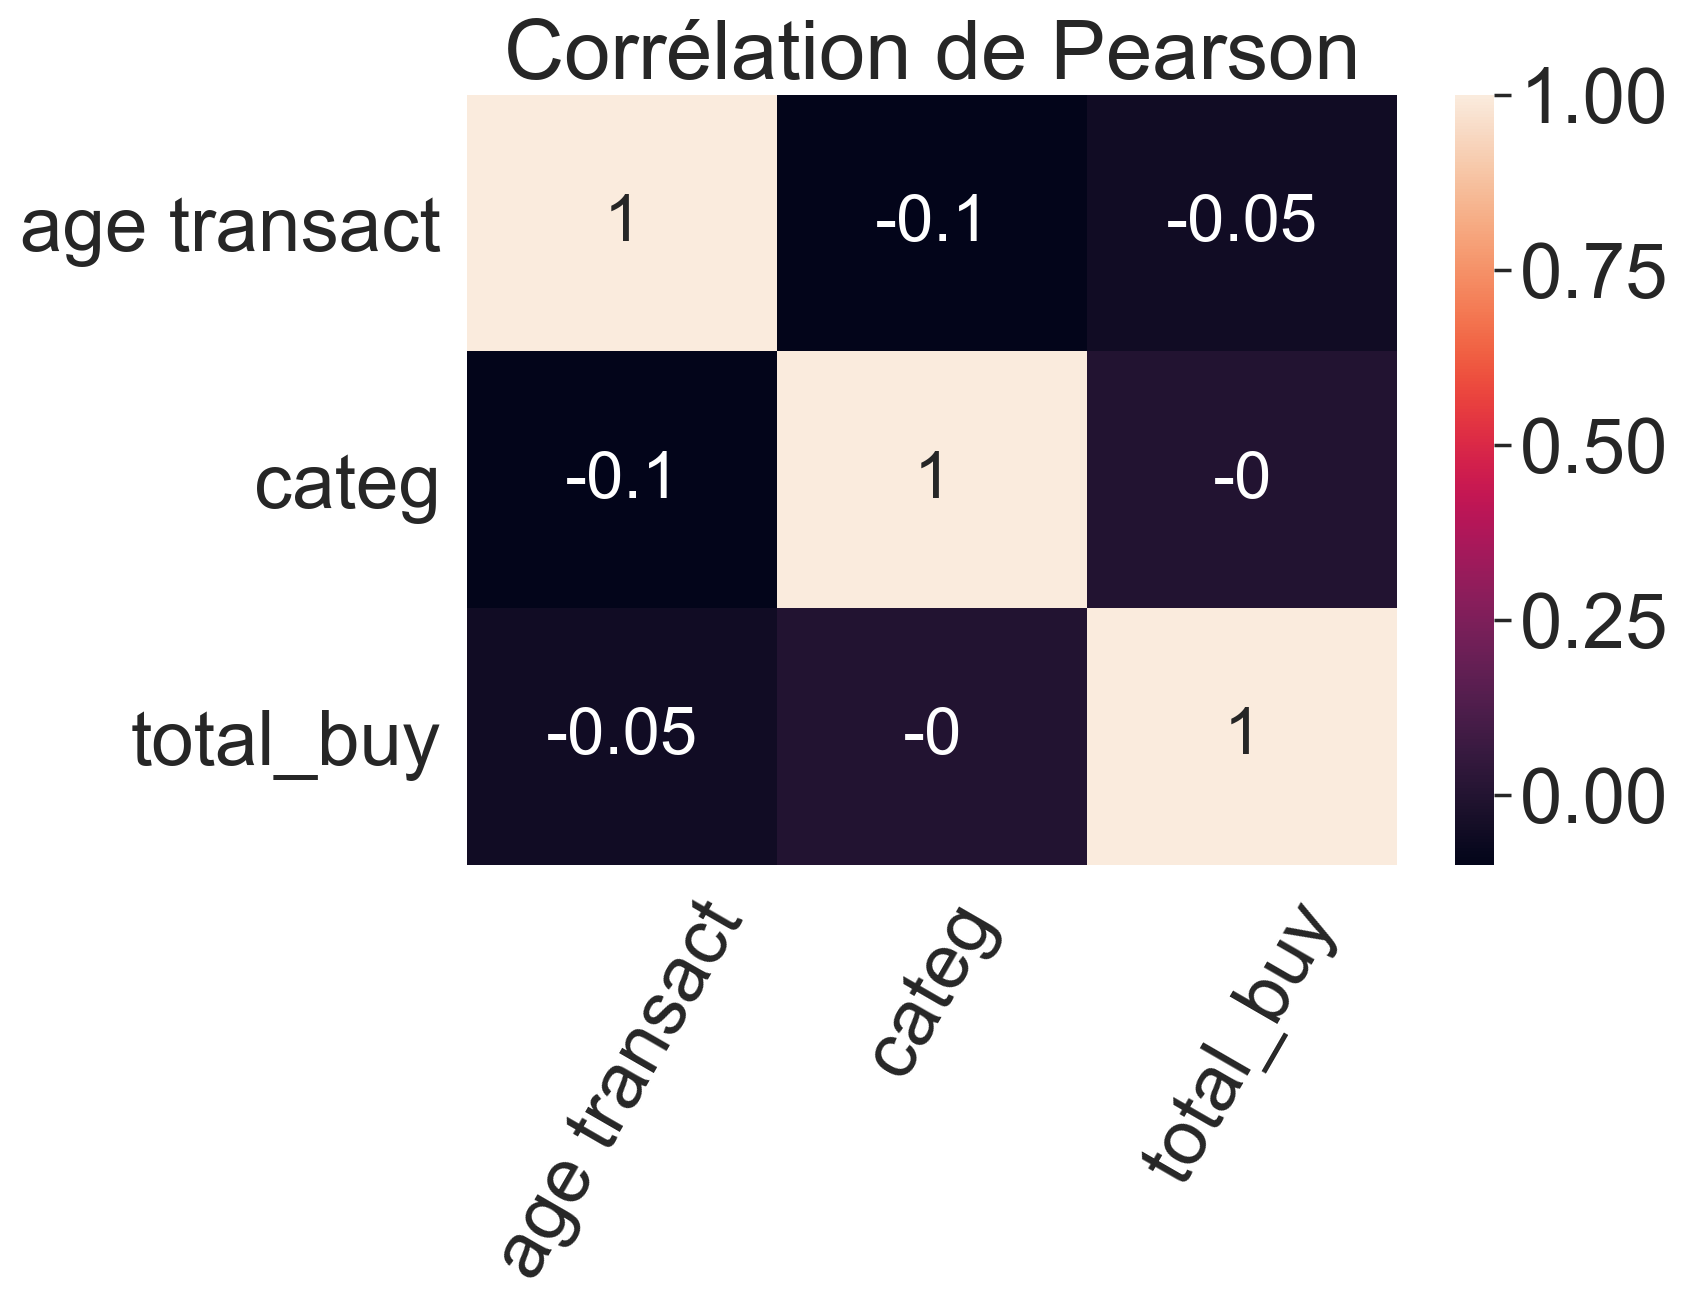

In [32]:
heatmap_age_categ_totalbuy = heatmap_data_librairie_clean.rename(columns={"moyenne_nb_prod_par_session": "pdt_session", "moyenne_nb_achat_par_mois": "session_mois"})
heatmap_age_categ_totalbuy2 = heatmap_age_categ_totalbuy[[ "age transact", "categ", "total_buy"]]
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(7.5,5), dpi=200)
plt.xticks(rotation=60)
plt.title("Corrélation de Pearson")
sns.heatmap(((heatmap_age_categ_totalbuy2.corr())).round(2), annot=True);  # coefficient de pearson
plt.savefig('./dataset_P4/Pearson_age_categ_totalbuy.png')

In [33]:
data_librairie_without_imputation["age_segment"] = np.where(data_librairie_without_imputation["age transact"] < 30, "18-30", (np.where(data_librairie_without_imputation["age transact"] > 50, "51+", "31-50")))

price_client_age = data_librairie_without_imputation[["client_id", "price"]]
price_client_age_trie = (price_client_age.groupby(by=[ "client_id"]).sum().reset_index())
price_client_age_trie["total_buy"] = price_client_age_trie["price"].round().astype('int')
price_client_age_totalbuy = price_client_age_trie.drop(columns={"price"})

price_client_age_totalbuy = price_client_age_totalbuy.merge(data_librairie_without_imputation)
price_client_age_totalbuy

,client_id,total_buy,moyenne_nb_prod_par_session,moyenne_nb_achat_par_mois,id_prod,date,session_id,price,categ,sex,birth,age transact,age_segment,male,achat_par_genre
0,1,301,1.333333,1.25,208,11,114737,54.87,2.0,1,1955,67,51+,1,1
1,1,301,1.333333,1.25,1571,14,158128,5.99,0.0,1,1955,68,51+,1,1
2,1,301,1.333333,1.25,425,12,139610,16.99,1.0,1,1955,67,51+,1,1
3,1,301,1.333333,1.25,364,11,120172,10.30,1.0,1,1955,67,51+,1,1
4,1,301,1.333333,1.25,364,12,134971,10.30,1.0,1,1955,67,51+,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336708,8621,1868,2.444444,5.25,909,12,132039,18.99,0.0,1,1988,34,31-50,1,1
336709,8621,1868,2.444444,5.25,33,9,88319,30.99,1.0,1,1988,34,31-50,1,1
336710,8621,1868,2.444444,5.25,1241,13,150848,1.99,0.0,1,1988,35,31-50,1,1
336711,8621,1868,2.444444,5.25,304,6,46126,17.72,0.0,1,1988,34,31-50,1,1


In [34]:
price_client_age_totalbuy2 = price_client_age_totalbuy.groupby(by=["client_id"]).mean().reset_index()
price_client_age_totalbuy3= price_client_age_totalbuy2[["client_id", "total_buy"]].merge(data_librairie_without_imputation, on=['client_id', "total_buy"])


price_client_age_totalbuy4 = price_client_age_totalbuy3[["client_id", "total_buy", "age_segment"]] #.sort_values(by=['total_buy'])

price_client_age_totalbuy5 = price_client_age_totalbuy4.drop_duplicates(subset=['client_id'])



chi2('total_buy','age_segment', price_client_age_totalbuy5)
# chi2('total_buy','age_segment', price_client_age_totalbuy)

# price_client_age_totalbuy5

F:\w10\Programme\Anaconda\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
F:\w10\Programme\Anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


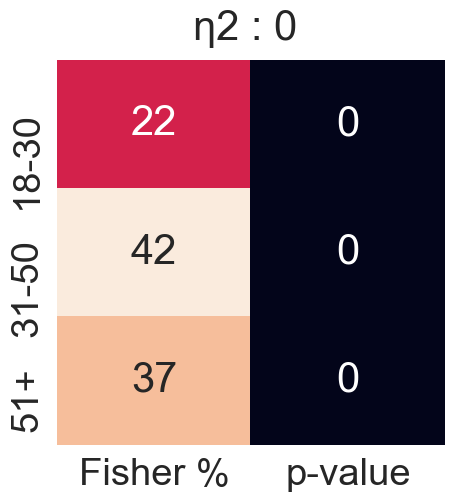

,client_id,total_buy,moyenne_nb_prod_par_session,moyenne_nb_achat_par_mois,id_prod,date,session_id,price,categ,sex,birth,age transact,age_segment,male,achat_par_genre
0,1,301,1.333333,1.25,208,11,114737,54.87,2.0,1,1955,67,51+,1,1
1,1,301,1.333333,1.25,1571,14,158128,5.99,0.0,1,1955,68,51+,1,1
2,1,301,1.333333,1.25,425,12,139610,16.99,1.0,1,1955,67,51+,1,1
3,1,301,1.333333,1.25,364,11,120172,10.30,1.0,1,1955,67,51+,1,1
4,1,301,1.333333,1.25,364,12,134971,10.30,1.0,1,1955,67,51+,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336708,8621,1868,2.444444,5.25,909,12,132039,18.99,0.0,1,1988,34,31-50,1,1
336709,8621,1868,2.444444,5.25,33,9,88319,30.99,1.0,1,1988,34,31-50,1,1
336710,8621,1868,2.444444,5.25,1241,13,150848,1.99,0.0,1,1988,35,31-50,1,1
336711,8621,1868,2.444444,5.25,304,6,46126,17.72,0.0,1,1988,34,31-50,1,1


In [35]:
eta2('total_buy','age_segment', price_client_age_totalbuy)
price_client_age_totalbuy

# Analyse relation entre l'âge des clients et les catégorie de produit

In [36]:
data_librairie_without_imputation["age_segment"] = np.where(data_librairie_without_imputation["age transact"] < 30, "   18-30", (np.where(data_librairie_without_imputation["age transact"] > 50, "   51+", "   31-50")))





chi2('categ','age_segment', data_librairie_without_imputation)

data_librairie_without_imputation.sort_values(by = 'age transact')

print("On appelle effectif cumulé croissant de la valeur xi, la somme des effectifs de toutes les valeurs du caractère inférieures ou égales à xi. ") 
print("On appelle effectif cumulé décroissant de la valeur xi, la somme des effectifs de toutes les valeurs du caractère supérieures ou égales à xi.")

print("Le test de Chi-deux est utilisé pour tester l'hypothèse nulle d'absence de relation entre deux variables catégorielles. On peut également dire que ce test vérifie l'hypothèse d'indépendance de ces variables.")
# print("si khi2 > 5% Pour déterminer si les variables sont indépendantes, comparez la valeur de p au seuil de signification. En général, un seuil de signification (noté alpha ou α) de 0,05 fonctionne bien. Un seuil de signification de 0,05 indique 5 % de risque de conclure à tort qu'il existe une association.
# Valeur de p ≤ α : les variables présentent une association statistiquement significative (rejeter H0)
# Si la valeur de p est inférieure ou égale au seuil de signification, vous pouvez rejeter l'hypothèse nulle et conclure qu'il existe une association statistiquement significative entre les variables.
# Valeur de p > α : impossible de conclure que les variables sont associées (ne pas rejeter H0)
# Si la valeur de p est supérieure au seuil de signification, vous ne pouvez pas rejeter l'hypothèse nulle, car vous ne possédez pas suffisamment de preuves pour conclure que les variables sont associées.


On appelle effectif cumulé croissant de la valeur xi, la somme des effectifs de toutes les valeurs du caractère inférieures ou égales à xi. 
On appelle effectif cumulé décroissant de la valeur xi, la somme des effectifs de toutes les valeurs du caractère supérieures ou égales à xi.
Le test de Chi-deux est utilisé pour tester l'hypothèse nulle d'absence de relation entre deux variables catégorielles. On peut également dire que ce test vérifie l'hypothèse d'indépendance de ces variables.


In [37]:
contigence_age_categ2 = data_librairie_without_imputation.pivot_table(values="price", index= "age_segment", columns= "categ", aggfunc= "count", margins = False)

from scipy.stats import chi2_contingency

chi2, p, dof, ex = chi2_contingency(contigence_age_categ2, correction=False)
print(chi2)
print(p)

139797.7529759348
0.0


In [38]:
contigence_age_categ2

categ,0.0,1.0,2.0
age_segment,,,
18-30,7627,13172,14804
31-50,160953,48338,1902
51+,40846,48225,846


In [39]:
contigence_age_categ = data_librairie_without_imputation.pivot_table(values="price", index= "age_segment", columns= "categ", aggfunc= "count", margins = True)
contigence_age_categ

contigence_age_categ_values = contigence_age_categ.values[-1][:-1]
x = contigence_age_categ_values.reshape(1,-1)
x

contigence_age_segment = contigence_age_categ["All"].values[:-1]
y = contigence_age_segment.reshape(1,-1)
y

zh = np.dot(y.T , x)/(contigence.values[-1][-1])
zh

zr = data_librairie_without_imputation.pivot_table(values="price", index = "age_segment", columns= "categ", aggfunc= "count").values
zr

Khi2 = ((zr-zh)**2/zr).sum()

Khi2 # = 127307 qui est > 14,86 (avec 0.5% d'erreur)



from scipy.stats import chi2
chi2.pdf(Khi2, df= 4) #=0
# rejet de l'hypothése nul (rejet de l'indépendance des variable) avec p=0


0.0

In [40]:
print(contigence_age_categ)
print(zr)
print(zh)


categ           0.0     1.0    2.0     All
age_segment                               
   18-30       7627   13172  14804   35603
   31-50     160953   48338   1902  211193
   51+        40846   48225    846   89917
All          209426  109735  17552  336713
[[  7627  13172  14804]
 [160953  48338   1902]
 [ 40846  48225    846]]
[[ 22144.06297945  11603.04236843   1855.89465212]
 [131356.09619468  68827.94503034  11008.95877498]
 [ 55925.84082587  29304.01260124   4687.1465729 ]]


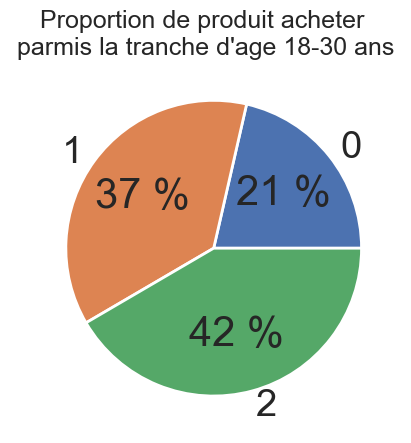

<Figure size 3000x2000 with 0 Axes>

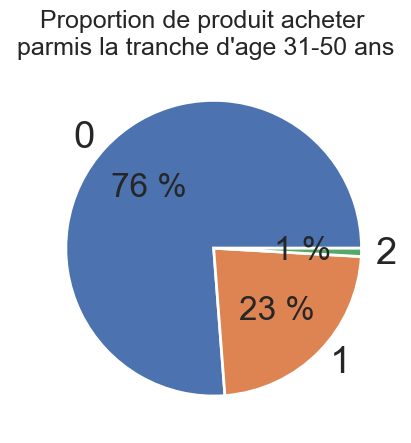

<Figure size 3000x2000 with 0 Axes>

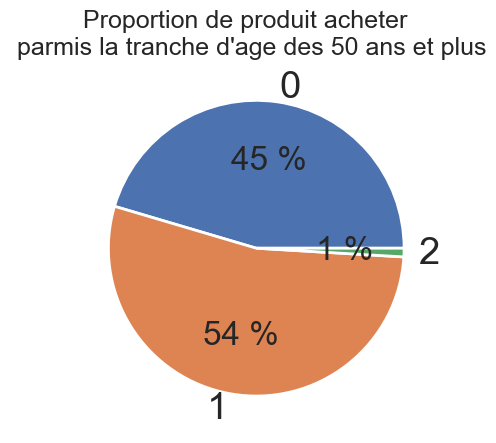

<Figure size 3000x2000 with 0 Axes>

In [41]:

zr[0]

plt.pie(zr[0], 
            labels=[0,1,2], 
            autopct=lambda x: str(int(round(x))) + ' %',  
            wedgeprops={'edgecolor' : 'w', 'linewidth' : 2},            
           )

plt.figtext(.5,.9,"Proportion de produit acheter \n parmis la tranche d'age 18-30 ans ", fontsize=18, ha='center')
plt.savefig('./dataset_P4/categ0_age.png')
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(15,10), dpi=200)
plt.show()

plt.pie(zr[1], 
            labels=[0,1,2], 
            autopct=lambda x: str(int(round(x))) + ' %',  
            wedgeprops={'edgecolor' : 'w', 'linewidth' : 2},            
           )

plt.figtext(.5,.9,"Proportion de produit acheter \n parmis la tranche d'age 31-50 ans ", fontsize=18, ha='center')
plt.savefig('./dataset_P4/categ1_age.png')
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(15,10), dpi=200)
plt.show()

plt.pie(zr[2], 
            labels=[0,1,2], 
            autopct=lambda x: str(int(round(x))) + ' %',  
            wedgeprops={'edgecolor' : 'w', 'linewidth' : 2},            
           )

plt.figtext(.5,.9,"Proportion de produit acheter \n parmis la tranche d'age des 50 ans et plus", fontsize=18, ha='center')
plt.savefig('./dataset_P4/categ2_age.png')
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(15,10), dpi=200)
plt.show()

# Relation entre l’âge des clients et le montant total des achats
## Corrélation de pearson (décomposés)

In [42]:
age_total_idclient = data_librairie_without_imputation[["client_id", "age transact", "total_buy" ]].drop_duplicates(subset=['client_id'])
X_age_total = list(age_total_idclient.mean(skipna = False).values)
ecartype_age_total = age_total_idclient.std().values
age_total_idclient["age-X"] = age_total_idclient["age transact"] - X_age_total[1]
age_total_idclient["total-X"] = age_total_idclient["total_buy"] - X_age_total[2]

age_total_idclient["covariance"] = age_total_idclient["age-X"] * age_total_idclient["total-X"]

coef_corrélation = age_total_idclient["covariance"].mean()/(ecartype_age_total[1]*ecartype_age_total[2])

coef_corrélation # = -0.03952

age_total_idclient[["age transact", "total_buy", "age-X", "total-X", "covariance"]]

,age transact,total_buy,age-X,total-X,covariance
0,67,301,23.078721,-373.025814,-8608.958660
20,66,586,22.078721,-88.025814,-1943.497381
48,30,223,-13.921279,-451.025814,6278.856224
54,57,980,13.078721,305.974186,4001.750991
110,41,1102,-2.921279,427.974186,-1250.232032
...,...,...,...,...,...
336590,67,119,23.078721,-555.025814,-12809.285869
336598,52,740,8.078721,65.974186,532.987038
336640,28,573,-15.921279,-101.025814,1608.460177
336663,21,1528,-22.921279,853.974186,-19574.180637


# Relation entre l’âge des clients et le nombre moyen d'article par session


In [43]:
age_taillepanier = data_librairie_without_imputation[["client_id","moyenne_nb_prod_par_session", "age_segment"]].drop_duplicates(subset=['client_id'])
age_taillepanier

,client_id,moyenne_nb_prod_par_session,age_segment
0,1,1.333333,51+
20,10,1.750000,51+
48,100,2.000000,31-50
54,1000,1.333333,51+
110,1001,2.416667,31-50
...,...,...,...
336590,995,1.600000,51+
336598,996,1.166667,51+
336640,997,2.300000,18-30
336663,998,2.153846,18-30


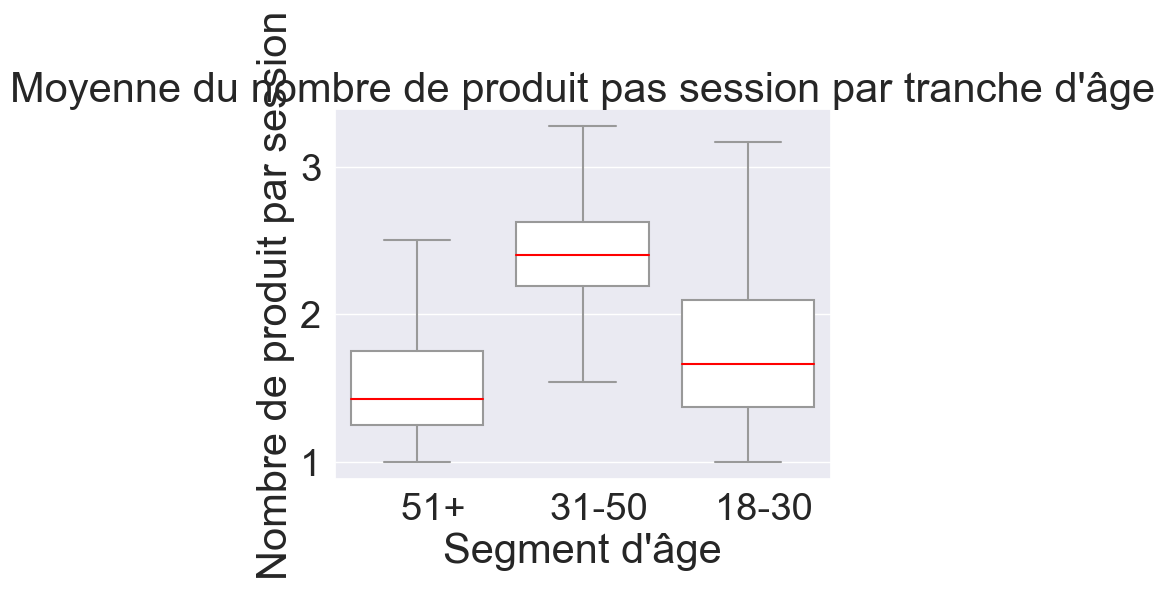

In [44]:

# figure settings
# plt.figure(figsize=(20,8), dpi=200)

sns.boxplot(
            x = age_taillepanier['age_segment'],
            y= age_taillepanier["moyenne_nb_prod_par_session"],
            data=age_taillepanier,
            showfliers = False, 
            color='w',
            medianprops={'color':'red'})
        
# plt.axis(ymax=15, ymin=0)
plt.title("Moyenne du nombre de produit pas session par tranche d'âge")
plt.ylabel("Nombre de produit par session")
plt.xlabel("Segment d'âge")
plt.savefig('./dataset_P4/age_pdt_par_session.png')



In [45]:
from scipy.stats import f_oneway

client = data_librairie_without_imputation.drop_duplicates(subset=['client_id'])

f_oneway(client[client["age_segment"] == "18-30"]["moyenne_nb_prod_par_session"], client[client["age_segment"] == "31-50"]["moyenne_nb_prod_par_session"], client[client["age_segment"] == "51+"]["moyenne_nb_prod_par_session"])

F:\w10\Programme\Anaconda\lib\site-packages\scipy\stats\stats.py:3612: F_onewayBadInputSizesWarning: at least one input has length 0
  warnings.warn(F_onewayBadInputSizesWarning('at least one input '


F_onewayResult(statistic=nan, pvalue=nan)

In [46]:
data_librairie_without_imputation

,client_id,moyenne_nb_prod_par_session,moyenne_nb_achat_par_mois,total_buy,id_prod,date,session_id,price,categ,sex,birth,age transact,age_segment,male,achat_par_genre
0,1,1.333333,1.25,301,208,11,114737,54.87,2.0,1,1955,67,51+,1,1
1,1,1.333333,1.25,301,1571,14,158128,5.99,0.0,1,1955,68,51+,1,1
2,1,1.333333,1.25,301,425,12,139610,16.99,1.0,1,1955,67,51+,1,1
3,1,1.333333,1.25,301,364,11,120172,10.30,1.0,1,1955,67,51+,1,1
4,1,1.333333,1.25,301,364,12,134971,10.30,1.0,1,1955,67,51+,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336708,999,1.047619,1.75,305,669,13,150872,15.99,1.0,1,1964,59,51+,1,1
336709,999,1.047619,1.75,305,2104,10,99070,7.98,0.0,1,1964,58,51+,1,1
336710,999,1.047619,1.75,305,247,13,154462,20.99,1.0,1,1964,59,51+,1,1
336711,999,1.047619,1.75,305,727,11,122996,16.99,1.0,1,1964,58,51+,1,1


# Analyse corrélation entre l’âge des clients et la fréquence d’achats


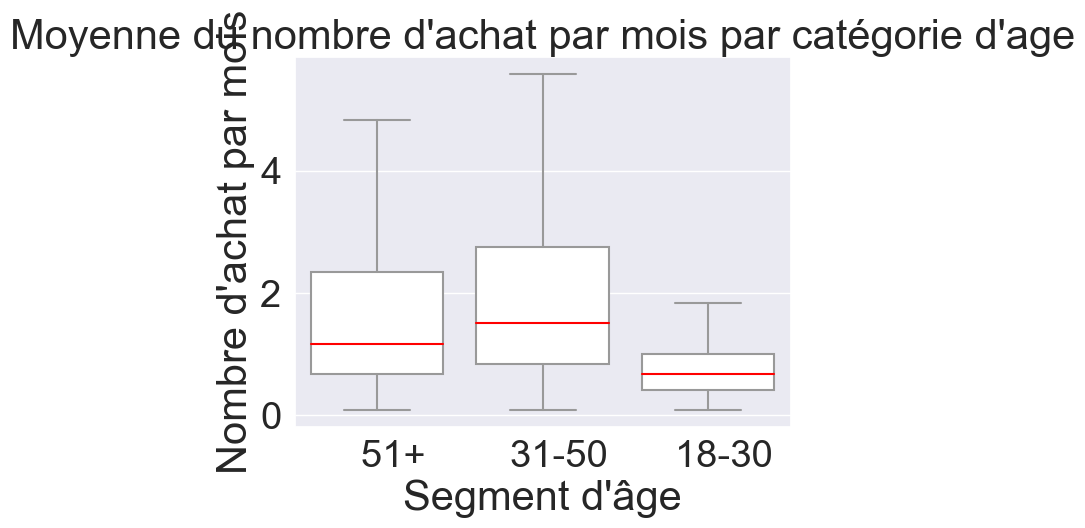

In [47]:
age_fréquence_achat = data_librairie_without_imputation[["client_id","moyenne_nb_achat_par_mois", "age_segment"]].drop_duplicates(subset=['client_id'])


# figure settings
# plt.figure(figsize=(20,8), dpi=200)

sns.boxplot(
            x = age_fréquence_achat['age_segment'],
            y= age_fréquence_achat["moyenne_nb_achat_par_mois"],
            data=age_fréquence_achat,
            showfliers = False, 
            color='w',
            medianprops={'color':'red'})
        
# plt.axis(ymax=15, ymin=0)
plt.title("Moyenne du nombre d'achat par mois par catégorie d'age")
plt.ylabel("Nombre d'achat par mois")
plt.xlabel("Segment d'âge")
plt.savefig('./dataset_P4/age_frequence_achat.png')



In [48]:
from scipy.stats import f_oneway

client = data_librairie_without_imputation.drop_duplicates(subset=['client_id'])

f_oneway(client[client["age_segment"] == "18-30"]["moyenne_nb_achat_par_mois"], client[client["age_segment"] == "31-50"]["moyenne_nb_achat_par_mois"], client[client["age_segment"] == "51+"]["moyenne_nb_achat_par_mois"])

F:\w10\Programme\Anaconda\lib\site-packages\scipy\stats\stats.py:3612: F_onewayBadInputSizesWarning: at least one input has length 0
  warnings.warn(F_onewayBadInputSizesWarning('at least one input '


F_onewayResult(statistic=nan, pvalue=nan)

# Analyse corrélation entre l’âge des clients et le total acheté

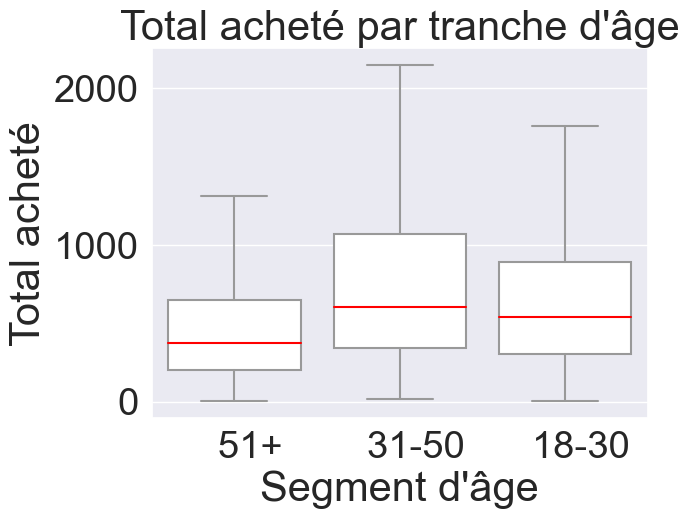

In [49]:
age_total_buy = data_librairie_without_imputation[["client_id","total_buy", "age_segment"]].drop_duplicates(subset=['client_id'])


# figure settings
# plt.figure(figsize=(20,8), dpi=200)

sns.boxplot(
            x = age_total_buy['age_segment'],
            y= age_total_buy["total_buy"],
            data=age_total_buy,
            showfliers = False, 
            color='w',
            medianprops={'color':'red'})
        
# plt.axis(ymax=15, ymin=0)
plt.title("Total acheté par tranche d'âge")
plt.ylabel("Total acheté")
plt.xlabel("Segment d'âge")
plt.savefig('./dataset_P4/age_total_buy.png')



In [50]:
from scipy.stats import f_oneway

client = data_librairie_without_imputation.drop_duplicates(subset=['client_id'])

f_oneway(client[client["age_segment"] == "18-30"]["total_buy"], client[client["age_segment"] == "31-50"]["total_buy"], client[client["age_segment"] == "51+"]["total_buy"])

F:\w10\Programme\Anaconda\lib\site-packages\scipy\stats\stats.py:3612: F_onewayBadInputSizesWarning: at least one input has length 0
  warnings.warn(F_onewayBadInputSizesWarning('at least one input '


F_onewayResult(statistic=nan, pvalue=nan)

In [51]:
data_librairie_without_imputation.drop

<bound method DataFrame.drop of         client_id  moyenne_nb_prod_par_session  moyenne_nb_achat_par_mois  \
0               1                     1.333333                       1.25   
1               1                     1.333333                       1.25   
2               1                     1.333333                       1.25   
3               1                     1.333333                       1.25   
4               1                     1.333333                       1.25   
...           ...                          ...                        ...   
336708        999                     1.047619                       1.75   
336709        999                     1.047619                       1.75   
336710        999                     1.047619                       1.75   
336711        999                     1.047619                       1.75   
336712        999                     1.047619                       1.75   

        total_buy  id_prod  date  session_i

 a-t-il une corrélation entre l'âge des clients et :
Le montant total des achats ;
La fréquence d’achat (ie. nombre d'achats par mois par exemple) ;
La taille du panier moyen (en nombre d’articles) ;
# Analyse corrélation avec des courbes de Lorenz


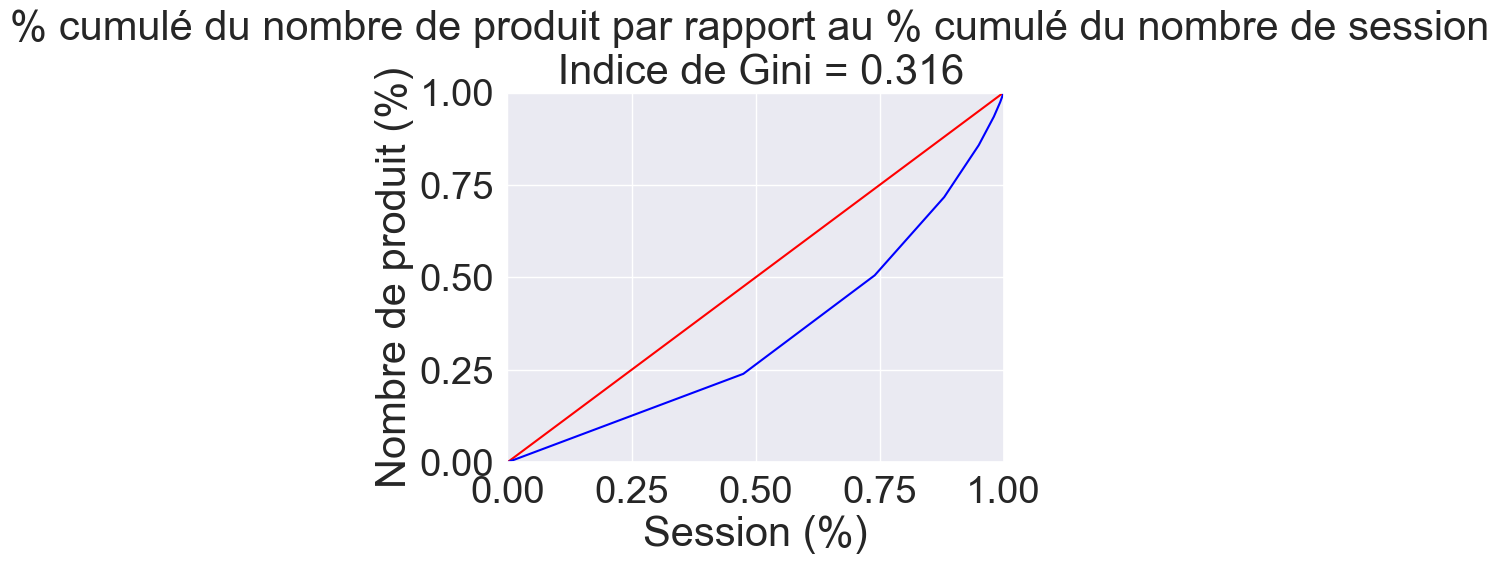

<Figure size 3600x2400 with 0 Axes>

In [52]:
product_session = data_librairie_without_imputation
product_session["produit_par_session"] = 1

nb_product_par_session = (product_session.pivot_table('produit_par_session', index = "session_id", aggfunc=sum)).sort_values(by = 'produit_par_session')

nb_product_par_session["%cumuléproduitparsession"] = nb_product_par_session["produit_par_session"].cumsum()/nb_product_par_session["produit_par_session"].sum()

nb_product_par_session["%cumulé_session"] = np.linspace(0,1, num= nb_product_par_session.index.nunique())

fig = plt.figure()
ax = plt.axes()

plt.axis([0, 1, 0, 1]);
plt.title("% cumulé du nombre de produit par rapport au % cumulé du nombre de session ")
plt.plot(nb_product_par_session["%cumulé_session"], nb_product_par_session["%cumulé_session"], color='red')
plt.title("% cumulé du nombre de produit par rapport au % cumulé du nombre de session \n Indice de Gini = 0.316")
plt.ylabel("Nombre de produit (%)")
plt.xlabel("Session (%)")
plt.figure(figsize=(18,12), dpi=200)


graph_produit_par_session_cumulé = ax.plot(nb_product_par_session["%cumulé_session"], nb_product_par_session["%cumuléproduitparsession"], color='blue', linestyle='solid', label='bleu');
graph_produit_par_session_cumulé
plt.savefig('./dataset_P4/Lorenz_gini_nbproduit_nbsession.png')

In [53]:
(0.5-((nb_product_par_session["%cumuléproduitparsession"]*(1/(nb_product_par_session["%cumuléproduitparsession"].nunique()))).sum()))*2 

0.3160481489534037

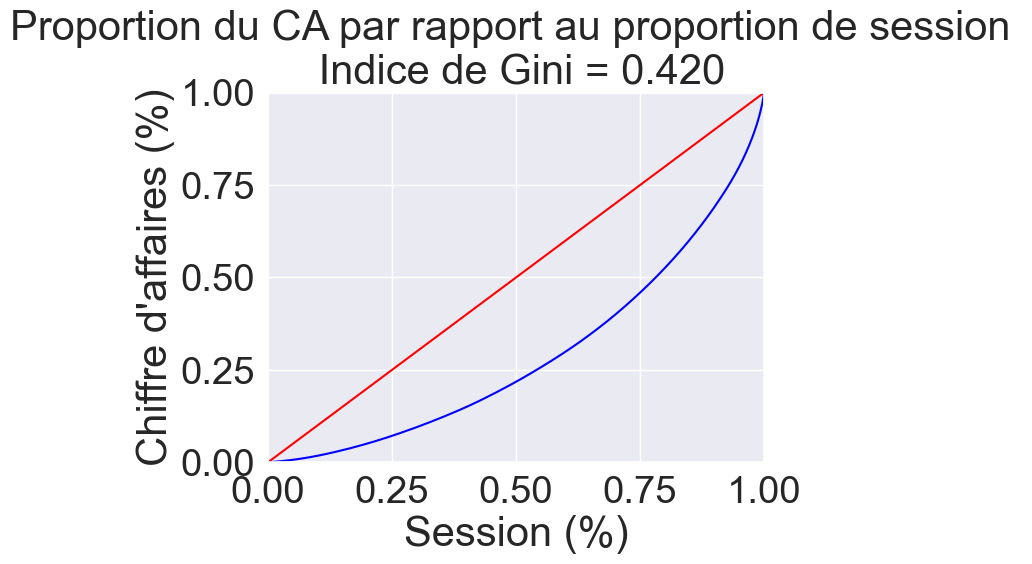

<Figure size 3600x2400 with 0 Axes>

In [54]:
CA_par_session = (data_librairie_without_imputation.pivot_table('price', index = "session_id", aggfunc=sum)).sort_values(by = 'price')

CA_par_session["%cumuléCAparsession"] = CA_par_session["price"].cumsum()/CA_par_session["price"].sum()

CA_par_session["%cumulé_session"] = np.linspace(0,1, num= CA_par_session.index.nunique())


fig = plt.figure()
ax = plt.axes()

plt.axis([0, 1, 0, 1]);
plt.plot(CA_par_session["%cumulé_session"], CA_par_session["%cumulé_session"], color='red')
plt.title("Proportion du CA par rapport au proportion de session \n Indice de Gini = 0.420")
plt.ylabel("Chiffre d'affaires (%)")
plt.xlabel("Session (%)")
plt.figure(figsize=(18,12), dpi=200)
plt.savefig('./dataset_P4/Lorenz_gini_CA_nbsession.png')


graph_CA_par_session_cumulé = ax.plot(CA_par_session["%cumulé_session"], CA_par_session["%cumuléCAparsession"], color='blue', linestyle='solid', label='bleu');
graph_CA_par_session_cumulé

In [55]:
(0.5-((CA_par_session["%cumuléCAparsession"]*(1/(CA_par_session["%cumuléCAparsession"].nunique()))).sum()))*2 

0.42046172418155625

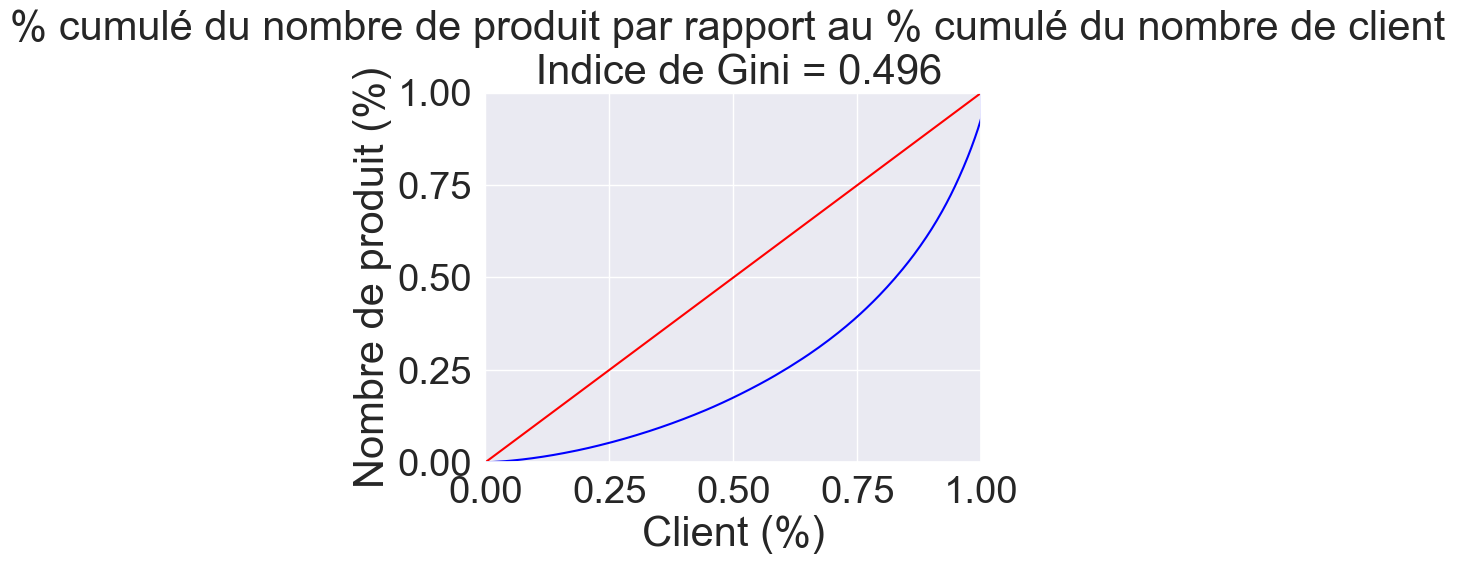

<Figure size 3600x2400 with 0 Axes>

In [56]:
product_client = data_librairie_without_imputation
product_client["produit_par_client"] = 1

nb_product_client = (product_client.pivot_table('produit_par_client', index = "client_id", aggfunc=sum)).sort_values(by = 'produit_par_client')

nb_product_client["%cumuléproduitparclient"] = nb_product_client["produit_par_client"].cumsum()/nb_product_client["produit_par_client"].sum()

nb_product_client["%cumulé_client"] = np.linspace(0,1, num= nb_product_client.index.nunique())

fig = plt.figure()
ax = plt.axes()

plt.axis([0, 1, 0, 1]);
plt.title("% cumulé du nombre de produit par rapport au % cumulé du nombre de client ")
plt.plot(nb_product_client["%cumulé_client"], nb_product_client["%cumulé_client"], color='red')
plt.title("% cumulé du nombre de produit par rapport au % cumulé du nombre de client \n Indice de Gini = 0.496")
plt.ylabel("Nombre de produit (%)")
plt.xlabel("Client (%)")
plt.figure(figsize=(18,12), dpi=200)
plt.savefig('./dataset_P4/Lorenz_gini_nbproduit_nbclient.png')


graph_produit_par_client_cumulé = ax.plot(nb_product_client["%cumulé_client"], nb_product_client["%cumuléproduitparclient"], color='blue', linestyle='solid', label='bleu');
graph_produit_par_client_cumulé

In [57]:
(0.5-((nb_product_client["%cumuléproduitparclient"]*(1/(nb_product_client["%cumuléproduitparclient"].nunique()))).sum()))*2 

0.49566692882262087

In [58]:
data_librairie_without_imputation

,client_id,moyenne_nb_prod_par_session,moyenne_nb_achat_par_mois,total_buy,id_prod,date,session_id,price,categ,sex,birth,age transact,age_segment,male,achat_par_genre,produit_par_session,produit_par_client
0,1,1.333333,1.25,301,208,11,114737,54.87,2.0,1,1955,67,51+,1,1,1,1
1,1,1.333333,1.25,301,1571,14,158128,5.99,0.0,1,1955,68,51+,1,1,1,1
2,1,1.333333,1.25,301,425,12,139610,16.99,1.0,1,1955,67,51+,1,1,1,1
3,1,1.333333,1.25,301,364,11,120172,10.30,1.0,1,1955,67,51+,1,1,1,1
4,1,1.333333,1.25,301,364,12,134971,10.30,1.0,1,1955,67,51+,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336708,999,1.047619,1.75,305,669,13,150872,15.99,1.0,1,1964,59,51+,1,1,1,1
336709,999,1.047619,1.75,305,2104,10,99070,7.98,0.0,1,1964,58,51+,1,1,1,1
336710,999,1.047619,1.75,305,247,13,154462,20.99,1.0,1,1964,59,51+,1,1,1,1
336711,999,1.047619,1.75,305,727,11,122996,16.99,1.0,1,1964,58,51+,1,1,1,1


# analyse de la corrélation entre la fréquence d'achat et le total acheter par les clients

In [59]:

nb_prod_par_session = (data_librairie_without_imputation["session_id"].value_counts()).value_counts()
nb_prod_par_session_df = pd.DataFrame(index = (np.linspace(1,13, num= nb_prod_par_session.nunique())), columns = [ 'nb de produit', 'occurrence' ])


nb_prod_par_session_df["occurrence"] = nb_prod_par_session
nb_prod_par_session_df["nb de produit"] = (np.linspace(1,13, num= nb_prod_par_session.nunique()))
nb_prod_par_session_df.loc[14]=[ 14, 1] #car supprimer la 1er ligne avec DF
(nb_prod_par_session_df["occurrence"][1])/(nb_prod_par_session_df["occurrence"].sum())
(nb_prod_par_session_df["occurrence"][1]+nb_prod_par_session_df["occurrence"][2]+nb_prod_par_session_df["occurrence"][3])/(nb_prod_par_session_df["occurrence"].sum())

0.8796025370478741

47% des panier ne contiennent seulement 1 produit
87% des panier contiennent entre 1 et 3 produits.

In [60]:
data_librairie_without_imputation

,client_id,moyenne_nb_prod_par_session,moyenne_nb_achat_par_mois,total_buy,id_prod,date,session_id,price,categ,sex,birth,age transact,age_segment,male,achat_par_genre,produit_par_session,produit_par_client
0,1,1.333333,1.25,301,208,11,114737,54.87,2.0,1,1955,67,51+,1,1,1,1
1,1,1.333333,1.25,301,1571,14,158128,5.99,0.0,1,1955,68,51+,1,1,1,1
2,1,1.333333,1.25,301,425,12,139610,16.99,1.0,1,1955,67,51+,1,1,1,1
3,1,1.333333,1.25,301,364,11,120172,10.30,1.0,1,1955,67,51+,1,1,1,1
4,1,1.333333,1.25,301,364,12,134971,10.30,1.0,1,1955,67,51+,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336708,999,1.047619,1.75,305,669,13,150872,15.99,1.0,1,1964,59,51+,1,1,1,1
336709,999,1.047619,1.75,305,2104,10,99070,7.98,0.0,1,1964,58,51+,1,1,1,1
336710,999,1.047619,1.75,305,247,13,154462,20.99,1.0,1,1964,59,51+,1,1,1,1
336711,999,1.047619,1.75,305,727,11,122996,16.99,1.0,1,1964,58,51+,1,1,1,1


In [61]:
segmeng_frequ_achat = data_librairie_without_imputation.drop_duplicates(subset=['client_id'])
segmeng_frequ_achat["frequ_achat_segment"] = np.where(segmeng_frequ_achat["moyenne_nb_achat_par_mois"] <= 0.5, 0.5, 
                                                      (np.where(segmeng_frequ_achat["moyenne_nb_achat_par_mois"] <= 1, 1,
                                                                (np.where(segmeng_frequ_achat["moyenne_nb_achat_par_mois"] <= 2, 2,
                                                                          (np.where(segmeng_frequ_achat["moyenne_nb_achat_par_mois"] <= 4, 4, 458)))))))
segmeng_frequ_achat["moyenne_nb_achat_par_mois"].describe()

<ipython-input-61-ff991295a532>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segmeng_frequ_achat["frequ_achat_segment"] = np.where(segmeng_frequ_achat["moyenne_nb_achat_par_mois"] <= 0.5, 0.5,


count    8600.000000
mean        1.639273
std         5.986014
min         0.083333
25%         0.583333
50%         1.083333
75%         2.083333
max       458.416667
Name: moyenne_nb_achat_par_mois, dtype: float64

F:\w10\Programme\Anaconda\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
F:\w10\Programme\Anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


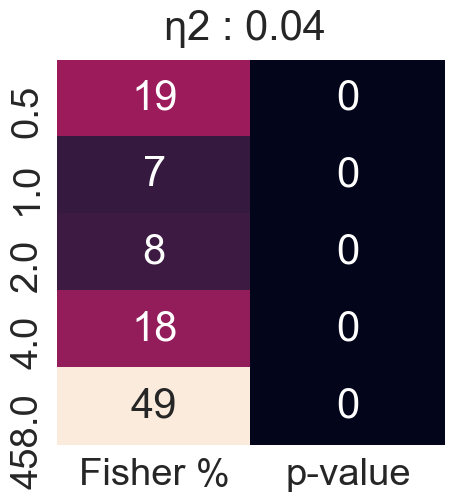

In [62]:
chi2('total_buy','frequ_achat_segment', segmeng_frequ_achat)
eta2('total_buy','frequ_achat_segment', segmeng_frequ_achat)



In [63]:
segmeng_frequ_achat = data_librairie_without_imputation.drop_duplicates(subset=['client_id']).copy()
segmeng_frequ_achat["frequ_achat_segment"] = np.where(segmeng_frequ_achat["moyenne_nb_achat_par_mois"] <= 0.5, 0.5, 
                                                      (np.where(segmeng_frequ_achat["moyenne_nb_achat_par_mois"] <= 1, 1,
                                                               (np.where(segmeng_frequ_achat["moyenne_nb_achat_par_mois"] <= 2, 2, 4)))))

segmeng_frequ_achat["total_buy_segment"] = np.where(segmeng_frequ_achat["total_buy"] <= 500, "0-500", 
                                                      (np.where(segmeng_frequ_achat["total_buy"] <= 1000, "0500-1000",
                                                                (np.where(segmeng_frequ_achat["total_buy"] <= 1500, "1000-1500", "1500+" )))))

totalbuy_frequ_segment = segmeng_frequ_achat[["total_buy_segment", "frequ_achat_segment"]]

totalbuy_frequ_segment["nb"] = 1

effectif_segment = totalbuy_frequ_segment.pivot_table('nb', index = "total_buy_segment", columns = "frequ_achat_segment", aggfunc=sum)

effectif_segment_clean = effectif_segment.fillna(0).reset_index()

effectif_segment_clean["total"] = effectif_segment_clean.sum(axis = 1)
effectif_segment_total = effectif_segment_clean.append({ 'total_buy_segment' : "total", 0.5 : 1809, 1.0 : 2347, 2.0 : 2243, 4.0 : 2201, "total" : 8600}, ignore_index=True)

# effectif_segment_clean[[0.5, 1.0, 2.0, 4.0]].sum()
effectif_segment_total # 1809, 2347, 2243, 2201, 8600

<ipython-input-63-746d7de5599c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totalbuy_frequ_segment["nb"] = 1


frequ_achat_segment,total_buy_segment,0.5,1.0,2.0,4.0,total
0,0-500,1731.0,1695.0,832.0,35.0,4293.0
1,0500-1000,78.0,604.0,1042.0,968.0,2692.0
2,1000-1500,0.0,46.0,276.0,770.0,1092.0
3,1500+,0.0,2.0,93.0,428.0,523.0
4,total,1809.0,2347.0,2243.0,2201.0,8600.0


In [64]:
effectif_segment_total_theorique = effectif_segment_total.copy()
effectif_segment_total_theorique[0.5] = (effectif_segment_total_theorique["total"]*(effectif_segment_total_theorique[0.5][4])/8600).round(1)
effectif_segment_total_theorique[1.0] = (effectif_segment_total_theorique["total"]*(effectif_segment_total_theorique[1.0][4])/8600).round(1)
effectif_segment_total_theorique[2.0] = (effectif_segment_total_theorique["total"]*(effectif_segment_total_theorique[2.0][4])/8600).round(1)
effectif_segment_total_theorique[4.0] = (effectif_segment_total_theorique["total"]*(effectif_segment_total_theorique[4.0][4])/8600).round(1)

khi2 = ((effectif_segment_total[[0.5, 1.0, 2.0, 4.0]] - effectif_segment_total_theorique[[0.5, 1.0, 2.0, 4.0]])**2) / effectif_segment_total_theorique[[0.5, 1.0, 2.0,4.0]]
khi2["total"] = khi2.sum(axis = 1)
khi2.iloc[4] = khi2.sum()


#  DDL = 9 ; alpha = 0.005 => indicateur théorique = 21.96

khi2
# from scipy.stats import chi2
# chi2.pdf(Khi2, df= 9) # p = 2.90.10**-14
# rejet de l'hypothése nul (rejet de l'indépendance des variable)


frequ_achat_segment,0.5,1.0,2.0,4.0,total
0,759.229236,233.823455,73.922738,1029.814954,2096.790383
1,421.043422,23.250973,164.552072,112.976778,721.823246
2,229.700000,213.100671,0.271910,860.788014,1303.860596
3,110.000000,138.728031,13.809091,645.965721,908.502842
4,1519.972658,608.903130,252.555812,2649.545467,5030.977067


In [65]:
effectif_segment_total

frequ_achat_segment,total_buy_segment,0.5,1.0,2.0,4.0,total
0,0-500,1731.0,1695.0,832.0,35.0,4293.0
1,0500-1000,78.0,604.0,1042.0,968.0,2692.0
2,1000-1500,0.0,46.0,276.0,770.0,1092.0
3,1500+,0.0,2.0,93.0,428.0,523.0
4,total,1809.0,2347.0,2243.0,2201.0,8600.0


In [66]:
data_librairie_without_imputation

,client_id,moyenne_nb_prod_par_session,moyenne_nb_achat_par_mois,total_buy,id_prod,date,session_id,price,categ,sex,birth,age transact,age_segment,male,achat_par_genre,produit_par_session,produit_par_client
0,1,1.333333,1.25,301,208,11,114737,54.87,2.0,1,1955,67,51+,1,1,1,1
1,1,1.333333,1.25,301,1571,14,158128,5.99,0.0,1,1955,68,51+,1,1,1,1
2,1,1.333333,1.25,301,425,12,139610,16.99,1.0,1,1955,67,51+,1,1,1,1
3,1,1.333333,1.25,301,364,11,120172,10.30,1.0,1,1955,67,51+,1,1,1,1
4,1,1.333333,1.25,301,364,12,134971,10.30,1.0,1,1955,67,51+,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336708,999,1.047619,1.75,305,669,13,150872,15.99,1.0,1,1964,59,51+,1,1,1,1
336709,999,1.047619,1.75,305,2104,10,99070,7.98,0.0,1,1964,58,51+,1,1,1,1
336710,999,1.047619,1.75,305,247,13,154462,20.99,1.0,1,1964,59,51+,1,1,1,1
336711,999,1.047619,1.75,305,727,11,122996,16.99,1.0,1,1964,58,51+,1,1,1,1


In [67]:
prix_moyen_par_session = data_librairie_without_imputation.pivot_table('price', index = "session_id", aggfunc=sum).copy()
prix_moyen_par_session.describe()

,price
count,169173.000000
mean,34.264202
std,31.872538
min,0.620000
25%,15.200000
50%,25.560000
75%,42.980000
max,539.230000


### On est donc sur à 999 chance sur mille que la fréquece d'achat et le total acheter par les clients sont dépendant, ce qui confirme que la plupart des clients sont fidèle et que la moyenne d'achat est stable.


# analyse de la corrélation entre le genre et la fréquence d'achat 

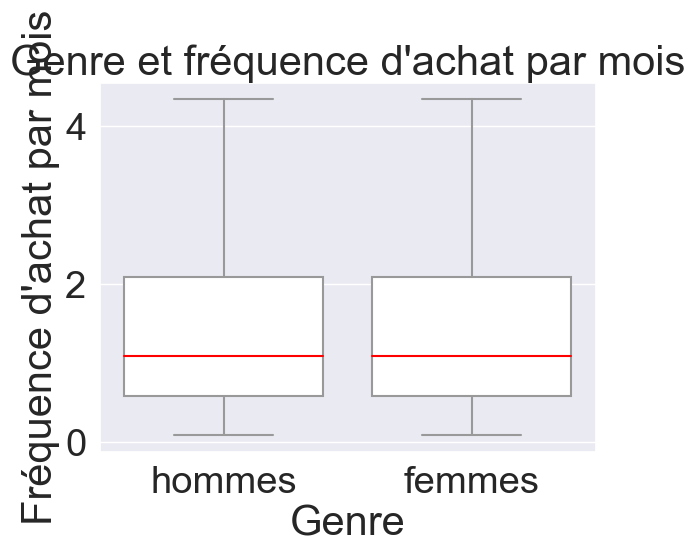

In [68]:
genre_frequence_achat = data_librairie_without_imputation[["client_id","moyenne_nb_achat_par_mois", "sex"]].drop_duplicates(subset=['client_id'])
genre_frequence_achat["sex"] = genre_frequence_achat["sex"].map({1 : "hommes",0 : "femmes"})



# figure settings
# plt.figure(figsize=(20,8), dpi=200)

sns.boxplot(
            x = genre_frequence_achat['sex'],
            y= genre_frequence_achat["moyenne_nb_achat_par_mois"],
            data=genre_frequence_achat,
            showfliers = False, 
            color='w',
            medianprops={'color':'red'})
        
# plt.axis(ymax=15, ymin=0)
plt.title("Genre et fréquence d'achat par mois")
plt.ylabel("Fréquence d'achat par mois")
plt.xlabel("Genre")
plt.savefig('./dataset_P4/genre_frequence_achat.png')



In [69]:
genre_frequence_achat

,client_id,moyenne_nb_achat_par_mois,sex
0,1,1.250000,hommes
20,10,1.333333,hommes
48,100,0.250000,hommes
54,1000,3.500000,femmes
110,1001,2.000000,hommes
...,...,...,...
336590,995,0.416667,hommes
336598,996,3.000000,femmes
336640,997,0.833333,femmes
336663,998,1.083333,hommes


# analyse de la corrélation entre le genre et le total acheter

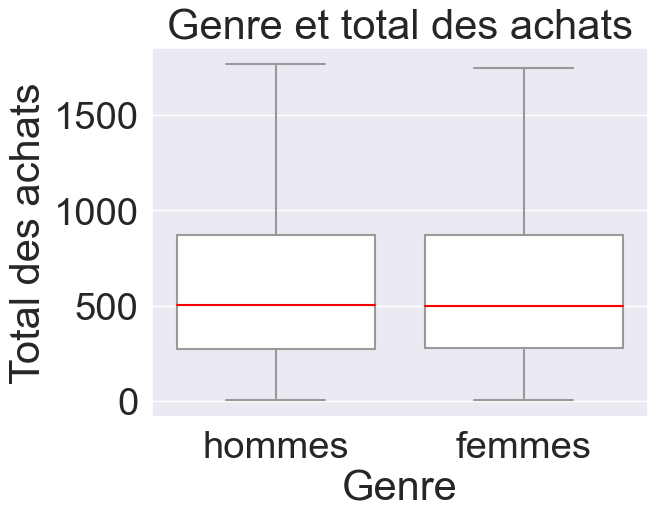

In [70]:
genre_total_achat = data_librairie_without_imputation[["client_id","total_buy", "sex"]].drop_duplicates(subset=['client_id'])
genre_total_achat["sex"] = genre_total_achat["sex"].map({1 : "hommes",0 : "femmes"})



# figure settings
# plt.figure(figsize=(20,8), dpi=200)

sns.boxplot(
            x = genre_total_achat['sex'],
            y= genre_total_achat["total_buy"],
            data=genre_total_achat,
            showfliers = False, 
            color='w',
            medianprops={'color':'red'})
        
plt.title("Genre et total des achats")
plt.ylabel("Total des achats")
plt.xlabel("Genre")
plt.savefig('./dataset_P4/genre_total_achat.png')

In [71]:
age_client = data_librairie_without_imputation.drop_duplicates(subset=['client_id']).pivot_table(values="price", index= "age transact", aggfunc= "count", margins = False).reset_index()


## Analyse des apports des jeunes hommes

In [72]:
x = data_librairie_without_imputation.pivot_table(values="price", index= "session_id", aggfunc= "sum", margins = False).reset_index()
x["price"].sum() # = 5796577.77 total CA

x2 = data_librairie_without_imputation_outlier.pivot_table(values="price", index= "session_id", aggfunc= "sum", margins = False).reset_index()
x2["price"].sum() # = 5634570.43 total CA sans outliers

CAjeunehomme = data_librairie_without_imputation[(data_librairie_without_imputation["sex"] == 1) & (data_librairie_without_imputation["age_segment"] == "18-30")]
# y = CAjeunehomme.pivot_table(values="price", index= "session_id", aggfunc= "sum", margins = False).reset_index()
# y

CAjeunehomme["price"].sum()/x["price"].sum() # 13% du CA annuel par jeune homme

CAjeunehomme.drop_duplicates(subset=['client_id']) # 1014 jeune homme client sur  8600 client (11.79%)
CAjeunehomme.drop_duplicates(subset=['session_id']) # 10969 session de jeune homme sur 169173 session (6.48%)
# data_librairie_without_imputation.drop_duplicates(subset=['session_id'])  # total 169173 session
1014/8600

0.11790697674418604

In [73]:
  data_librairie_without_imputation.head(100)

,client_id,moyenne_nb_prod_par_session,moyenne_nb_achat_par_mois,total_buy,id_prod,date,session_id,price,categ,sex,birth,age transact,age_segment,male,achat_par_genre,produit_par_session,produit_par_client
0,1,1.333333,1.25,301,208,11,114737,54.87,2.0,1,1955,67,51+,1,1,1,1
1,1,1.333333,1.25,301,1571,14,158128,5.99,0.0,1,1955,68,51+,1,1,1,1
2,1,1.333333,1.25,301,425,12,139610,16.99,1.0,1,1955,67,51+,1,1,1,1
3,1,1.333333,1.25,301,364,11,120172,10.30,1.0,1,1955,67,51+,1,1,1,1
4,1,1.333333,1.25,301,364,12,134971,10.30,1.0,1,1955,67,51+,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1000,1.333333,3.50,980,1139,9,94790,3.99,0.0,0,1966,56,51+,0,-1,1,1
96,1000,1.333333,3.50,980,265,6,44470,24.99,1.0,0,1966,56,51+,0,-1,1,1
97,1000,1.333333,3.50,980,249,7,62716,22.99,1.0,0,1966,56,51+,0,-1,1,1
98,1000,1.333333,3.50,980,325,5,42154,27.99,1.0,0,1966,56,51+,0,-1,1,1
